In [3]:
from collections.abc import Iterable
import os

from adjustText import adjust_text
from datetime import datetime, timedelta
from dateutil import tz
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.container import Container
from hdmf.data_utils import DataChunkIterator
import latex
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import pickle
from pynwb import load_namespaces, get_class, register_class, NWBFile, TimeSeries, NWBHDF5IO
from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, DfOverF, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from pynwb.core import NWBDataInterface
from pynwb.epoch import TimeIntervals
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
import pywt
import scipy.io as sio
import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import skimage.io as skio
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from tifffile import TiffFile
import tifffile

from networkx import kamada_kawai_layout

from atlas import loadmat, NPAtlas, NWBAtlas
from process_file import get_nwb_neurons, get_dataset_neurons, get_dataset_online, combine_datasets, get_pairings, get_color_discrim, get_neur_nums
from stats import get_summary_stats, analyze_pairs, get_accuracy
from visualization import plot_num_heatmap, plot_std_heatmap, plot_summary_stats, plot_color_discrim, plot_accuracies, plot_visualizations_atlas, plot_visualizations_data, plot_atlas2d_super
from utils import covar_to_coord, convert_coordinates, maha_dist, run_linear_assignment

# ndx_mulitchannel_volume is the novel NWB extension for multichannel optophysiology in C. elegans
from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume, MultiChannelVolumeSeries

In [2]:
import os
import PyQt6.QtCore 
os.environ["QT_API"] = "pyqt6"


## Figure 1: Visualizations of NWB file contents

## Atlas and data visualizations

In [4]:
NWB_atlas_full = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2024_03_11_match_full_nosplit.pkl')
NP_atlas = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2024_03_11_NPonly.pkl')

In [5]:
NP_atlas = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2024_03_11_NP_split/ex7_YAaLR.pkl')

In [6]:
NP_atlas = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/NP_original.pkl') #Atlas trained on just original 10 NeuroPAL datasets

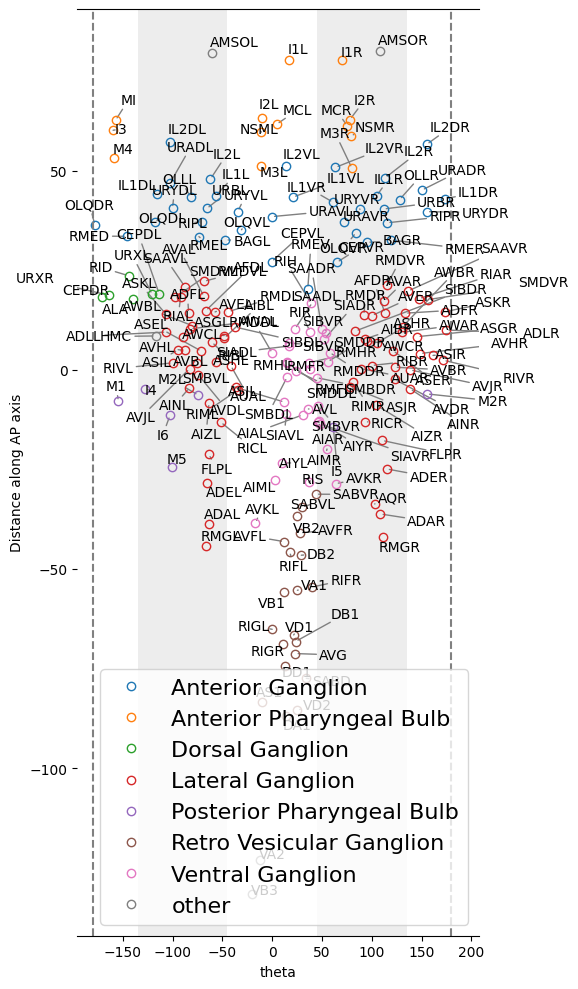

In [7]:
def plot_atlas_unrolled(atlas):
    """df needs: x/y/zcyl, ganglion, h, theta """

    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(6)

    ax1 = plt.subplot2grid(shape=(10,6), loc=(0,0), colspan=6, rowspan=10)
    atlas_df = atlas.get_df(vRecenter=[60, 10, -10])

    atlas_df = atlas_df.sort_values(by=['ID'], ignore_index=True)

    ganglia = sorted(atlas_df['ganglion'].unique())

    OBJECTS = []
    for g in ganglia:
        dfg = atlas_df[atlas_df['ganglion'] == g]
        OBJECTS.append(ax1.plot(dfg['theta'], dfg['h'], 'o', lw=0, label=g, markerfacecolor='None'))

    OBJECTS = [object for l in OBJECTS for object in l]
    ax1.axvspan(-135, -45, edgecolor=None, color='lightgrey', alpha=0.4, zorder=0, lw=0)
    ax1.axvspan(45, 135, edgecolor=None, color='lightgrey', alpha=0.4, zorder=0, lw=0)
    ax1.axvline(-180, ls='--', color='grey')
    ax1.axvline(180, ls='--', color='grey')
    ax1.set_xlabel('theta')
    ax1.set_ylabel('Distance along AP axis')
    ax1.legend(fontsize=16)

    TEXTS = []
    for i, row in atlas_df.iterrows():
        x = row['theta']
        y = row['h']
        TEXTS.append(ax1.text(x,y, row['ID'], fontsize=10))

    adjust_text(
        TEXTS,
        arrowprops = dict(arrowstyle="-", color='gray'),
        time_lim = 5,
        force_text = (0.3,0.3),
        ensure_inside_axes = False,
        expand_axes = True,
        ax=ax1
    )

    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)


    plt.tight_layout()
    plt.show()

plot_atlas_unrolled(NWB_atlas_full)
#plot_atlas_unrolled(NP_atlas)

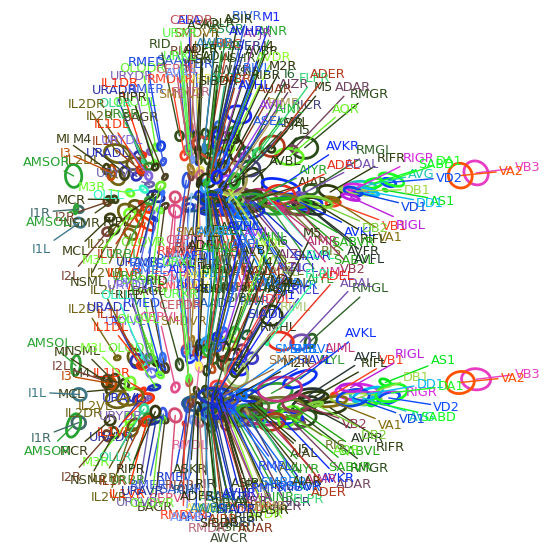

In [10]:
import networkx as nx

def plot_atlas_2d(atlas):
    plt.rcParams.update({'font.size':16})

    labels = atlas.neurons

    xyz_sigma = atlas.xyzsigma
    rgb_sigma = atlas.rgbsigma

    xyz_mu = atlas.xyzmu
    rgb_mu = atlas.rgbmu

    fig, axs = plt.subplots(2,1,sharex=True)

    TEXTSxy = []
    TEXTSxz = []
    for i in range(xyz_sigma.shape[2]):
        atlas.draw_ellipse(xyz_mu[i,[0,1]],xyz_sigma[0:2,0:2,i],atlas.atlas_color[i,:3], std_devs=1, ax=axs[1],line_width=2)
        atlas.draw_ellipse(xyz_mu[i,[0,2]],xyz_sigma[[0,2],:,i][:,[0,2]],atlas.atlas_color[i,:3], std_devs = 1, ax=axs[0],line_width=2)
        
        x = xyz_mu[i,0]
        y = xyz_mu[i,1]
        z = xyz_mu[i,2]

        color = atlas.atlas_color[i,:3]

        #TEXTSxy.append(axs[1].text(x,y, df_original.loc[i,'ID'], color=color, fontsize=5))
        #TEXTSxz.append(axs[0].text(x,z, df_original.loc[i,'ID'], color=color, fontsize=5))

    label_pos_xy = xyz_mu[:,[0,1]]
    label_pos_xz = xyz_mu[:,[0,2]]
    colors = atlas.atlas_color[:,:3]

    def repel_labels(ax, x, y, labels, k=0.1): #From https://stackoverflow.com/questions/14938541/how-to-improve-the-label-placement-in-scatter-plot
        G = nx.DiGraph()
        data_nodes = []
        init_pos =  {}
        for xi, yi, label in zip(x,y,labels):
            data_str = 'data_{0}'.format(label)
            G.add_node(data_str)
            G.add_node(label)
            G.add_edge(label, data_str)
            data_nodes.append(data_str)
            init_pos[data_str] = (xi, yi)
            init_pos[label] = (xi, yi)

        pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)

        pos_after = np.vstack([pos[d] for d in data_nodes])
        pos_before = np.vstack([init_pos[d] for d in data_nodes])
        scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0],1)
        scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1],1)
        shift = np.array([shift_x, shift_y])
        for key, val in pos.items():
            pos[key] = (val*scale) + shift

        for i, (label, data_str) in enumerate(G.edges()):
            ax.annotate(label,
                        xy=pos[data_str], xycoords='data',
                        xytext=pos[label], textcoords='data', fontsize= 'xx-small', color=colors[i,:],
                        arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0, connectionstyle='arc3', color=colors[i,:]))

        all_pos = np.vstack([value for value in pos.values()])
        x_span, y_span = np.ptp(all_pos, axis=0)
        mins = np.min(all_pos-x_span*0.15, 0)
        maxs = np.max(all_pos+y_span*0.15, 0)
        ax.set_xlim([mins[0], maxs[0]])
        ax.set_ylim([mins[1], maxs[1]])

    repel_labels(axs[0], label_pos_xz[:,0], label_pos_xz[:,1], labels, k=4)
    repel_labels(axs[1], label_pos_xy[:,0], label_pos_xy[:,1], labels, k=4)
        
    #axs[0].set_aspect('equal')
    axs[0].grid()
    axs[0].set_ylabel('')
    axs[0].set_ylim((-30,5))
    axs[0].invert_yaxis()
    axs[0].set_yticks([])
    axs[0].set_xlim((-25,150))
    axs[0].autoscale_view()

    #axs[1].set_aspect('equal')
    axs[1].grid()
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_xlabel('')
    axs[1].set_ylabel('')
    axs[1].set_ylim((-5,30))
    axs[1].set_xlim((-25,170))
    axs[1].autoscale_view()
    
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)

    axs[0].grid(False)
    axs[1].grid(False)

    plt.show()

plot_atlas_2d(NWB_atlas_full)



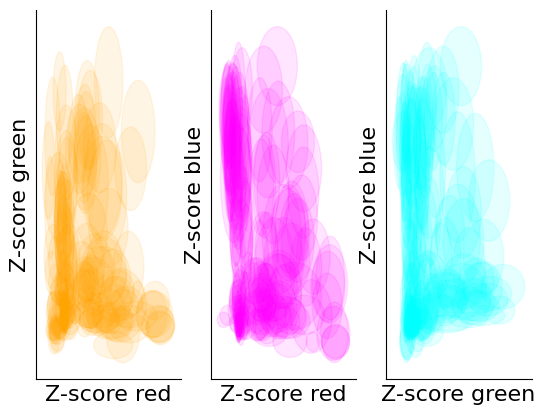

In [11]:
def plot_atlas_color(atlas):
    rgb_mu = atlas.rgbmu
    rgb_sigma = atlas.rgbsigma

    fig, axs = plt.subplots(1,3)

    for n in range(rgb_sigma.shape[2]):
        
        rgl1, rgl2, rgtheta = covar_to_coord(rgb_sigma[[0,1],:,n][:,[0,1]])
        rbl1, rbl2, rbtheta = covar_to_coord(rgb_sigma[[0,2],:,n][:,[0,2]])
        gbl1, gbl2, gbtheta = covar_to_coord(rgb_sigma[[1,2],:,n][:,[1,2]])

        rmu = rgb_mu[n, 0]
        gmu = rgb_mu[n, 1]
        bmu = rgb_mu[n, 2]
        
        #looking at only half a std to make it easier to visualize 
        rg_ellipse = Ellipse((rmu,gmu), width =rgl1*2, height = rgl2*2, angle=rgtheta*180/np.pi, alpha=0.1, edgecolor='orange', facecolor='orange')
        axs[0].add_patch(rg_ellipse)
        rb_ellipse = Ellipse((rmu, bmu), width =rbl1*2, height = rbl2*2, angle=rbtheta*180/np.pi, alpha=0.1, edgecolor='magenta', facecolor='magenta')
        axs[1].add_patch(rb_ellipse)
        gb_ellipse = Ellipse((gmu, bmu), width =gbl1*2, height = gbl2*2, angle=gbtheta*180/np.pi, alpha=0.1, edgecolor='cyan', facecolor='cyan')
        axs[2].add_patch(gb_ellipse)

    axs[0].set_xlabel('Z-score red')
    axs[0].set_ylabel('Z-score green')
    axs[1].set_xlabel('Z-score red')
    axs[1].set_ylabel('Z-score blue')
    axs[2].set_xlabel('Z-score green')
    axs[2].set_ylabel('Z-score blue')

    for ax in axs:
    #    ax.set_aspect('equal')
        #ax.set_xlim(-5,35)
        #ax.set_ylim(-5,35)
        ax.autoscale_view()
        ax.set_xticks([])
        ax.set_yticks([])
    
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    axs[2].spines['top'].set_visible(False)
    
    plt.show()

plot_atlas_color(NWB_atlas_full)

In [12]:
#%matplotlib qt
'''
Plot unrolled, color plots, and XY/XZ projections of individual dataset
'''

df_data = pd.read_csv('/Users/danielysprague/foco_lab/data/aligned_2024_03_11/aligned_full/11_YAaLR.csv')
#df_data = pd.read_csv('/Users/danielysprague/foco_lab/data/for_kevin/aligned_NP_nomatch/20230918-13-21-0.csv')
#df_data = pd.read_csv('/Users/danielysprague/foco_lab/data/aligned_2024_03_11/aligned_NP_split/7_YAaLR.csv')
df_data = df_data.rename(columns={"aligned_x":"X","aligned_y":"Y","aligned_z":"Z", "aligned_R":"R", "aligned_G":"G", "aligned_B":"B"})

#plot_visualizations_data(df_data, NWB_atlas_full, vRecenter = [60,10,-10])
#lot_data_2d(df_data, NWB_atlas_full)
#plot_data_unrolled(df_data, NP_atlas)

#plot_data_unrolled(df_data, NP_atlas, vRecenter = [60, 10, -10])
#plot_data_2d(df_data, NP_atlas)

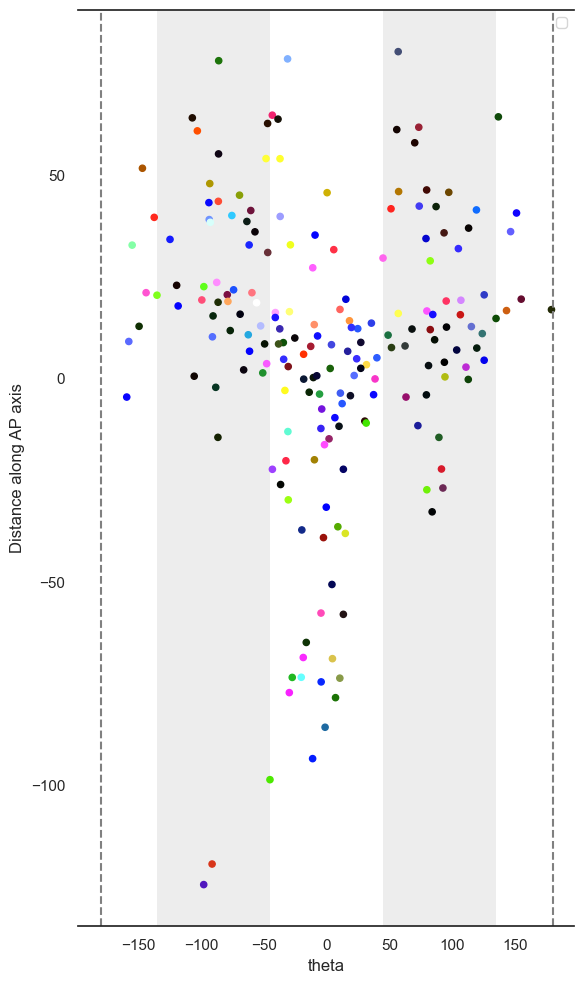

In [13]:
def plot_data_unrolled(df_data, atlas, vRecenter = [0,0,0]):
    """df needs: x/y/zcyl, ganglion, h, theta """

    xyz = np.asarray(df_data[['X','Y','Z']])

    xyz = atlas.project_atlas_components(xyz)

    df_data['X'] = xyz[:,0]
    df_data['Y'] = xyz[:,1]
    df_data['Z'] = xyz[:,2]

    df_data = convert_coordinates(df_data, vRecenter=vRecenter)

    rgb_data = np.asarray(df_data[['R', 'G', 'B']])

    marker_size = 20

    colors_min = np.amin(rgb_data, axis=0)
    colors_max = np.amax(rgb_data, axis=0)
    color_norm = np.divide(rgb_data-colors_min, colors_max-colors_min)

    sns.set_theme(style='white')
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(6)

    ax1 = plt.subplot2grid(shape=(10,6), loc=(0,0), colspan=6, rowspan=10)
    atlas_df = atlas.get_df(vRecenter=[60, 10, -10])

    ax1.scatter(df_data['theta'], df_data['h'], c=color_norm, s=marker_size)

    ax1.axvspan(-135, -45, edgecolor=None, color='lightgrey', alpha=0.4, zorder=0, lw=0)
    ax1.axvspan(45, 135, edgecolor=None, color='lightgrey', alpha=0.4, zorder=0, lw=0)
    ax1.axvline(-180, ls='--', color='grey')
    ax1.axvline(180, ls='--', color='grey')
    ax1.set_xlabel('theta')
    ax1.set_ylabel('Distance along AP axis')
    ax1.legend(fontsize=10)

    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)


    plt.tight_layout()
    plt.show()

plot_data_unrolled(df_data, NWB_atlas_full, vRecenter = [60, 10, -10])

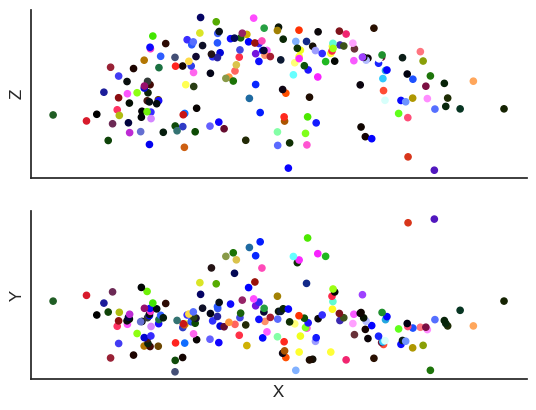

In [14]:
def plot_data_2d(df_data, atlas):
    plt.rcParams.update({'font.size':30})

    xyz = np.asarray(df_data[['X','Y','Z']])

    xyz = atlas.project_atlas_components(xyz)

    df_data['X'] = xyz[:,0]
    df_data['Y'] = xyz[:,1]
    df_data['Z'] = xyz[:,2]

    rgb_data = np.asarray(df_data[['R', 'G', 'B']])

    marker_size = 20

    colors_min = np.amin(rgb_data, axis=0)
    colors_max = np.amax(rgb_data, axis=0)
    color_norm = np.divide(rgb_data-colors_min, colors_max-colors_min)

    fig, axs = plt.subplots(2,1,sharex=True)

    axs[0].scatter(df_data['X'], df_data['Z'], c=color_norm, s=marker_size)
    axs[1].scatter(df_data['X'], df_data['Y'], c=color_norm, s=marker_size)
        
    axs[0].grid()
    axs[0].set_ylabel('Z')
    #axs[4].set_ylim((-15,15))
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].invert_yaxis()
    #axs[0].set_xlim((-5,180))
    axs[0].autoscale_view()

    axs[1].grid()
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    #axs[5].set_ylim((-15,15))
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    #axs[1].set_xlim((-5,180))
    axs[1].autoscale_view()

    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)

    axs[0].grid(False)
    axs[1].grid(False)

    plt.show()

plot_data_2d(df_data, NWB_atlas_full)



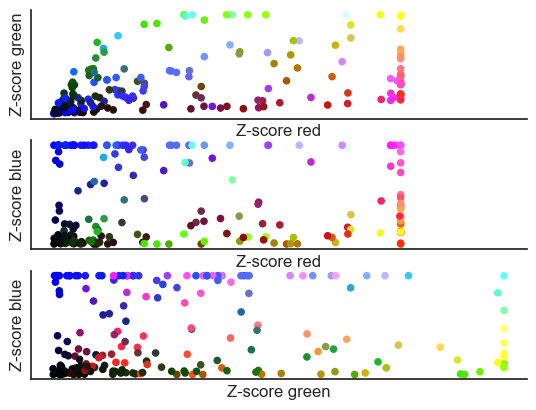

In [15]:
def plot_data_color(df_data, atlas):

    rgb_data = np.asarray(df_data[['R', 'G', 'B']])

    marker_size = 20

    colors_min = np.amin(rgb_data, axis=0)
    colors_max = np.amax(rgb_data, axis=0)
    color_norm = np.divide(rgb_data-colors_min, colors_max-colors_min)

    fig, axs = plt.subplots(3,1, sharex=True)

    for ax in axs:
        #ax.set_aspect('equal')
        #ax.set_xlim(-5,35)
        #ax.set_ylim(-5,35)
        ax.set_xticks([])
        ax.set_yticks([])

    axs[0].scatter(rgb_data[:,0], rgb_data[:,1], c=color_norm, s=marker_size)
    axs[1].scatter(rgb_data[:,0], rgb_data[:,2], c=color_norm, s=marker_size)
    axs[2].scatter(rgb_data[:,1], rgb_data[:,2], c=color_norm, s=marker_size)

    axs[0].set_xlabel('red')
    axs[0].set_ylabel('green')
    axs[1].set_xlabel('red')
    axs[1].set_ylabel('blue')
    axs[2].set_xlabel('green')
    axs[2].set_ylabel('blue')

    axs[0].set_xlabel('Z-score red')
    axs[0].set_ylabel('Z-score green')
    axs[1].set_xlabel('Z-score red')
    axs[1].set_ylabel('Z-score blue')
    axs[2].set_xlabel('Z-score green')
    axs[2].set_ylabel('Z-score blue')

    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    axs[2].spines['top'].set_visible(False)
    
    plt.show()

plot_data_color(df_data, NWB_atlas_full)

## raw images

In [22]:
filepath = '/Users/danielysprague/foco_lab/data/final_nwb/SK1/20230506-15-01-45.nwb'

with NWBHDF5IO(filepath, mode='r', load_namespaces=True) as io:
    read_nwb = io.read()

    seg = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons'].voxel_mask[:]
    labels = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons']['ID_labels'][:]
    channels = read_nwb.acquisition['NeuroPALImageRaw'].RGBW_channels[:] #get which channels of the image correspond to which RGBW pseudocolors
    image = read_nwb.acquisition['NeuroPALImageRaw'].data[:]
    scale = read_nwb.imaging_planes['NeuroPALImVol'].grid_spacing[:] #get which channels of the image correspond to which RGBW pseudocolors

    calc_image1 = np.max(read_nwb.acquisition['CalciumImageSeries'].data[0:50, :,:,:], axis=0)
    calc_image2 = np.max(read_nwb.acquisition['CalciumImageSeries'].data[100:150, :,:,:], axis=0)
    calc_image3 = np.max(read_nwb.acquisition['CalciumImageSeries'].data[200:250, :,:,:], axis=0)
    rate = read_nwb.acquisition['CalciumImageSeries'].rate
    #fluor = read_nwb.processing['CalciumActivity']['CalciumFluorescence']['SignalCalciumImResponseSeries'].data[:]

In [25]:
im1 = np.transpose(np.max(calc_image1, axis=2))
im1 = im1.astype('uint16')
im2 = np.transpose(np.max(calc_image2, axis=2))
im2 = im2.astype('uint16')
im3 = np.transpose(np.max(calc_image3, axis=2))
im3 = im3.astype('uint16')

tifffile.imwrite('/Users/danielysprague/foco_lab/data/calc_images/calc_image1.tif', im1, imagej=True)
tifffile.imwrite('/Users/danielysprague/foco_lab/data/calc_images/calc_image2.tif', im2, imagej=True)
tifffile.imwrite('/Users/danielysprague/foco_lab/data/calc_images/calc_image3.tif', im3, imagej=True)

In [24]:
from dandi.dandiapi import DandiAPIClient
import remfile
import h5py

dandi_id = '000776'

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandi_id, 'draft')
    for asset in dandiset.get_assets():
        s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)
        file = remfile.File(s3_url)

        with h5py.File(file, 'r') as f:
            with NWBHDF5IO(file=f, mode='r',load_namespaces=True) as io:
                read_nwb = io.read()
                read_nwb.acquisition.pop('CalciumImageSeries')
                identifier = read_nwb.identifier

                export_filename = '/Users/danielysprague/foco_lab/data/final_nwb/SF/'+ identifier + '.nwb'
                with NWBHDF5IO(export_filename, mode="w") as export_io:
                    export_io.export(src_io=io, nwbfile=read_nwb)



## Figure 2: C. elegans extension and NWB architecture


## Table 1: Summary of collected datasetes

## Figure 3: Benchmarking performance of curated datasets on different atlases

In [16]:
'''
Call get_dataset_neurons for each data source folder that you want to process. Returns a df with all blobs across
all files in the source folder, with an additional column to show which file that blob came from

You can read nwb files locally or use get_dataset_online with dandi_id to stream from an online dandiset

Call get_summary_stats and plot_summary_stats to get the number of segmented and IDd neurons by dataset and plot
on bar plot
'''

#atlas = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2023_12_19_full'+'.pkl')
atlas = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2023_12_13_2_full.pkl')
atlas_df = atlas.get_df()
atlas_neurons = np.asarray(atlas_df['ID'])

EY_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/final_nwb/EY', atlas_neurons) #dandi_id = 000541
SK1_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/final_nwb/SK1', atlas_neurons) #dandi_id = 000565
NP_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/final_nwb/NP_og', atlas_neurons) #dandi_id = 000715
SK2_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/final_nwb/SK2', atlas_neurons) #dandi_id = 000472
HL_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/final_nwb/HL', atlas_neurons) #dandi_id = 000714
KK_dataset = get_dataset_online('000692', atlas_neurons) #dandi_id = 000692
SF_dataset = get_dataset_online('000776', atlas_neurons) #dandi_id = 000776

20190928_08
20190929_02
20190929_03
20190925_01
20191030_07
20190925_04
20191030_03
20190929_05
20190929_07
20190929_06
20191104_10
20191104_08
20190924_01
20190928_01
20190928_03
20190924_03
20190924_02
20190928_13
20190928_07
20190928_11
20190928_05
20230412-20-15-17
20230506-14-24-57
20230510-13-25-46
20230322-22-43-03
20221106-21-47-31
20230506-12-56-00
20221106-21-00-09
20230322-20-16-50
20221028-18-48-00
20230506-15-33-51
20230510-15-49-47
20230904-15-09-05
20221215-20-02-49
20230909-16-48-09
20230904-14-30-52
20230322-21-41-10
20221106-21-23-19
20230506-15-01-45
20230510-12-53-34
20230904-15-59-40
20230322-18-57-04
56_YAaDV
38_YAaDV
76_YAaDV
11_YAaLR
64_YAaDV
70_YAaLR
55_YAaDV
7_YAaLR
62_YAaLR
20_YAaLR
2021-12-03-w00-NP1
2022-03-05-w00-NP1
2022-02-12-w00-NP1
2022-02-22-w04-NP1
2022-02-11-w03-NP1
2022-02-12-w01-NP1
2022-01-22-w04-NP1
2022-04-26-w01-NP1
2022-04-26-w00-NP1
2022-04-01-w00-NP1
2
3
1
4
5
7
6
8
9
20230918-9-54-0
20230928-14-27-0
20230928-11-14-0
20230918-13-21-0
202309

In [17]:
def maha_dist(data, mu, sigma):

    data_mu = data-mu
    inv_sigma = np.linalg.inv(sigma)
    left_data = np.dot(data_mu, inv_sigma)
    mahal = np.dot(left_data, data_mu.T)

    return np.sqrt(mahal)
def run_linear_assignment(df_data, atlas):
    #df_data should have columns 'X', 'Y', 'Z', 'R', 'G', 'B', 'ID' 

    df_assigns = df_data.copy()

    mu = atlas.mu
    sigma = atlas.sigma
    neurons = np.asarray(atlas.neurons)

    xyzrgb = np.asarray(df_data[['X','Y','Z','R','G','B']])
    gt_labels = np.asarray(df_data['ID'])

    assigns = np.empty((xyzrgb.shape[0],5),np.dtype('U100'))
    assign_cost = np.zeros((xyzrgb.shape[0], 3, 5)) #total, position, color in second dimension, top 5 ranks in third 

    cost_mat = np.zeros((xyzrgb.shape[0], mu.shape[0]))
    cost_pos = np.zeros((xyzrgb.shape[0], mu.shape[0]))
    cost_col = np.zeros((xyzrgb.shape[0], mu.shape[0]))

    for i in range(xyzrgb.shape[0]):
        for j in range(mu.shape[0]):
            #print(neurons[j])
            cost = maha_dist(xyzrgb[i,:], mu[j,:], sigma[:,:,j])
            cost_pos[i,j] = maha_dist(xyzrgb[i,:3], mu[j,:3], sigma[:3,:3,j])
            cost_col[i,j] = maha_dist(xyzrgb[i,3:], mu[j,3:], sigma[3:,3:,j])

            cost_mat[i,j] = cost

    for k in range(5):

        row_inds, col_inds = linear_sum_assignment(cost_mat)

        assigns[row_inds,k] = np.asarray(neurons[col_inds])

        assign_cost[row_inds, 0, k] = cost_mat[row_inds, col_inds]
        assign_cost[row_inds, 1, k] = cost_pos[row_inds, col_inds]
        assign_cost[row_inds, 2, k] = cost_col[row_inds, col_inds]

        cost_mat[row_inds, col_inds] = np.inf

    #figure out case where more rows than columns 

    df_assigns['assign_1'] = assigns[:,0]
    df_assigns['assign_2'] = assigns[:,1]
    df_assigns['assign_3'] = assigns[:,2]
    df_assigns['assign_4'] = assigns[:,3]
    df_assigns['assign_5'] = assigns[:,4]

    return df_assigns, assign_cost

In [18]:
def get_accuracies(folder, atlas):
    acc_df = pd.DataFrame(columns=['Total_neurons','Percent_IDd', 'Percent_top1', 'Percent_top2', 'Percent_top3', 'Percent_top4', 'Percent_top5', 'Filename'])
    for file in os.listdir(folder):
        if not file[-4:] == '.csv':
            continue

        df_data = pd.read_csv(folder + '/'+file)
        df_data = df_data.rename(columns={"aligned_x":"X","aligned_y":"Y","aligned_z":"Z", "aligned_R":"R", "aligned_G":"G", "aligned_B":"B"})

        df, costs = run_linear_assignment(df_data, atlas)

        IDd = df[~df['ID'].isnull()]

        per_ID = len(IDd.index)/len(df.index)

        total_neurons = len(df.index)

        corr1 = df.loc[df['ID']==df['assign_1']]
        corr2 = df.loc[df['ID']==df['assign_2']]
        corr3 = df.loc[df['ID']==df['assign_3']]
        corr4 = df.loc[df['ID']==df['assign_4']]
        corr5 = df.loc[df['ID']==df['assign_5']]
            
        corr_cum_2 = pd.concat([corr1,corr2]).drop_duplicates().reset_index(drop=True)
        corr_cum_3 = pd.concat([corr_cum_2,corr3]).drop_duplicates().reset_index(drop=True)
        corr_cum_4 = pd.concat([corr_cum_3,corr4]).drop_duplicates().reset_index(drop=True)
        corr_cum_5 = pd.concat([corr_cum_4, corr5]).drop_duplicates().reset_index(drop=True)

        per_corr_1 = len(corr1.index)/len(IDd.index)
        per_corr_2 = len(corr_cum_2.index)/len(IDd.index)
        per_corr_3 = len(corr_cum_3.index)/len(IDd.index)
        per_corr_4 = len(corr_cum_4.index)/len(IDd.index)
        per_corr_5 = len(corr_cum_5.index)/len(IDd.index)

        acc_df.loc[len(acc_df.index)] = [total_neurons,per_ID, per_corr_1, per_corr_2, per_corr_3, per_corr_4, per_corr_5, file[:-4]]

    return acc_df

In [19]:
NP_atlas_match = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2024_03_11_NPonly.pkl') #Atlas trained on just original 10 NeuroPAL datasets
NP_atlas_unmatch = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2024_03_11_NPunmatch.pkl')

accs_NP = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_2024_03_11/aligned_NP', NP_atlas_match)
accs_NP_unmatch = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_2024_03_11/aligned_NP_nomatch', NP_atlas_unmatch)

In [20]:
for i in range(5):
    full_atlas_match = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2024_03_11_split/exgroup'+str(i)+'.pkl') 
    full_atlas_unmatch = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2024_03_11_split_unmatch/exgroup'+str(i)+'.pkl')

    accs_match = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_2024_03_11/aligned_split/group'+str(i+1), full_atlas_match)
    accs_unmatch = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_2024_03_11/aligned_split_nomatch/group'+str(i+1), full_atlas_unmatch)

    if i==0:
        accs_full = accs_match
        accs_full_unmatch = accs_unmatch
    else:
        accs_full = pd.concat([accs_full, accs_match])
        accs_full_unmatch = pd.concat([accs_full_unmatch, accs_unmatch])

In [21]:
full_nosplit_atlas = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2024_03_11_match_full_nosplit.pkl')

accs_full_nosplit = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_2024_03_11/aligned_full', full_nosplit_atlas)

In [22]:
skipfiles = ['20231013-9-30-0', '20230412-20-15-17', '2023-01-23-01', '20239828-11-14-0', '2023-01-05-01', '2023-01-10-14', '2022-06-28-07', '2022-07-26-01', '2023-01-19-15', '2022-07-15-06', '2022-08-02-01', '2023-01-09-08', '2023-01-09-28', '2023-01-10-14', '2023-01-17-14', '2023-01-19-22', '2023-01-23-01']

In [47]:
%matplotlib qt


def gen_plots_acc(datasets, labels,accs_NP_unmatch, accs_NP, accs_full_unmatch, accs_full):

    plt.rcParams.update({'font.size': 60})

    df_dataset = pd.DataFrame(columns=['Atlas', 'Dataset', 'Accuracy'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            if key in skipfiles: #skip files
                continue
            acc_NP_unmatch = accs_NP_unmatch.loc[accs_NP_unmatch['Filename']==key]
            acc_NP = accs_NP.loc[accs_NP['Filename']==key]
            acc_full_unmatch = accs_full_unmatch.loc[accs_full_unmatch['Filename']==key]
            acc_full = accs_full.loc[accs_full['Filename']==key]

            df_dataset.loc[len(df_dataset.index)] = ['Base', labels[i], acc_NP_unmatch.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Matched', labels[i], acc_NP.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Full', labels[i], acc_full_unmatch.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Full matched', labels[i], acc_full.iloc[0]['Percent_top1']]

    df_ranks = pd.DataFrame(columns= ['Atlas', 'Rank', 'Accuracy'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            if key in skipfiles:
                continue
            acc_NP_unmatch = accs_NP_unmatch.loc[accs_NP_unmatch['Filename']==key]
            acc_NP = accs_NP.loc[accs_NP['Filename']==key]
            acc_full_unmatch = accs_full_unmatch.loc[accs_full_unmatch['Filename']==key]
            acc_full = accs_full.loc[accs_full['Filename']==key]

            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top', acc_NP_unmatch.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top', acc_NP.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top', acc_full_unmatch.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top', acc_full.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top2', acc_NP_unmatch.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top2', acc_NP.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top2', acc_full_unmatch.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top2', acc_full.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top3', acc_NP_unmatch.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top3', acc_NP.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top3', acc_full_unmatch.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top3', acc_full.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top4', acc_NP_unmatch.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top4', acc_NP.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top4', acc_full_unmatch.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top4', acc_full.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top5', acc_NP_unmatch.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top5', acc_NP.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top5', acc_full_unmatch.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top5', acc_full.iloc[0]['Percent_top4']]

    palette = sns.color_palette('colorblind')
    color1 = palette[3]
    color2 = palette[2]
    color3 = palette[0]
    color4 = palette[8]
    color5 = palette[4]
    color6 = palette[6]

    axs = plt.figure(layout="constrained").subplot_mosaic(
        """
        AB
        AC
        """
    )

    sns.set(style='white', font_scale=1.5)

    for key in axs.keys():
        axs[key].spines[['right', 'top']].set_visible (False)
        axs[key].axhline(1.0, ls='--', c='grey')
        axs[key].axhline(0.75, ls='--', c='grey')
        axs[key].axhline(0.5, ls='--', c='grey')
        axs[key].axhline(0.25, ls='--', c='grey')

    # Calculate mean and standard error of the mean for each category
    df_nofull = df_dataset[df_dataset['Atlas']!='Full']
    stats = df_nofull.groupby('Atlas')['Accuracy'].agg(['mean', 'sem']).reset_index()

    #sns.violinplot(ax=axs[0][0], data = df_dataset[df_dataset['Atlas']=='NP_unmatch'], x='Dataset', y='Accuracy', palette=['purple'], inner='quart', density_norm='width')

    sns.violinplot(ax = axs['A'], data=df_dataset[df_dataset['Atlas']!='Full'], x='Atlas', y='Accuracy', hue='Atlas', palette=[color1, color2, color4], cut=0, inner='point', density_norm='width', inner_kws = {})
    #sns.stripplot(ax= axs['A'], data=df_dataset, x='Atlas', y='Accuracy', hue='Atlas', palette=[color1, color2, color3, color4],)

    # Add horizontal lines for mean and standard error of the mean
    for i, row in stats.iterrows():
        cat_index = np.where(df_nofull['Atlas'].unique() == row['Atlas'])[0][0]
        axs['A'].axhline(y=row['mean'], color='red', linestyle='-', linewidth=3, xmin=cat_index/len(df_nofull['Atlas'].unique()), xmax=(cat_index+1)/len(df_nofull['Atlas'].unique()))
        #axs['A'].errorbar(x=cat_index, y=row['mean'], yerr=row['sem'], color='black', fmt = 'o')

    sns.violinplot(ax= axs['B'], data = df_ranks[(df_ranks['Atlas']=='Original') | (df_ranks['Atlas']=='Multi-lab + color corrected')], x = 'Rank', y='Accuracy', hue='Atlas', gap=0.5, palette=[color1, color4], orient='v', split=True, cut=0, inner='quart', density_norm='width')
    #sns.violinplot(ax= axs['B'], data = df_dataset[(df_dataset['Atlas']=='Base')|(df_dataset['Atlas']=='Matched')], x = 'Dataset', y='Accuracy', hue='Atlas', gap=0.5, palette=[color1, color2], orient='v', split=True, cut=0, inner='quart', density_norm='width') 
    sns.violinplot(ax= axs['C'], data = df_dataset[(df_dataset['Atlas']=='Base')|(df_dataset['Atlas']=='Full matched')], x = 'Dataset', y='Accuracy', hue='Atlas', gap=0.5, palette=[color1, color4], orient='v', split=True, cut=0, inner='quart', density_norm='width') 
    #sns.violinplot(ax= axs['D'], data = df_dataset[(df_dataset['Atlas']=='Full')|(df_dataset['Atlas']=='Full matched')], x = 'Dataset', y='Accuracy', hue='Atlas', gap=0.5,  palette=[color3, color4], orient='v', split=True, cut=0, inner='quart', density_norm='width') 
    #sns.violinplot(ax= axs[2][0], data = df_dataset[(df_dataset['Atlas']=='Full')|(df_dataset['Atlas']=='Full matched')], x = 'Dataset', y='Accuracy', hue='Atlas', gap=0.5, palette=[color3, color4], orient='v', split=True, cut=0, inner='quart', density_norm='width') 
    #sns.violinplot(ax= axs[2][1], data = df_dataset[(df_dataset['Atlas']=='Base')|(df_dataset['Atlas']=='Full matched')], x = 'Dataset', y='Accuracy', hue='Atlas', gap=0.5, palette=[color1, color4], orient='v', split=True, cut=0, inner='quart', density_norm='width') 
    
    accs_base = np.asarray(df_dataset[df_dataset['Atlas'] == 'Base']['Accuracy'])
    accs_match = np.asarray(df_dataset[df_dataset['Atlas'] == 'Matched']['Accuracy'])
    accs_fullnomatch = np.asarray(df_dataset[df_dataset['Atlas'] == 'Full']['Accuracy'])
    accs_fullmatch = np.asarray(df_dataset[df_dataset['Atlas'] == 'Full matched']['Accuracy'])

    for i, dataset in enumerate(labels):
        NP_unmatch_vals = df_dataset[(df_dataset['Dataset']==dataset)&(df_dataset['Atlas']=='Base')]['Accuracy']
        NP_vals = df_dataset[(df_dataset['Dataset']==dataset)&(df_dataset['Atlas']=='Matched')]['Accuracy']
        consol_unmatch_vals = df_dataset[(df_dataset['Dataset']==dataset)&(df_dataset['Atlas']=='Full')]['Accuracy']
        consol_vals = df_dataset[(df_dataset['Dataset']==dataset)&(df_dataset['Atlas']=='Full matched')]['Accuracy']

        for a, b, c, d in zip(NP_unmatch_vals, NP_vals, consol_unmatch_vals, consol_vals):
            #axs['B'].plot([i-0.1,i+0.1], [a,b], color='black', linewidth=0.5)
            axs['C'].plot([i-0.1,i+0.1], [a,d], color='black', linewidth=0.5)
            #axs['D'].plot([i-0.1,i+0.1], [c,d], color='black', linewidth=0.5)
            #axs[2][0].plot([i-0.1,i+0.1], [c,d], color='black', linewidth=0.5)
            #axs[2][1].plot([i-0.1,i+0.1], [a,d], color='black', linewidth=0.5)

    ranks = ['top', 'top2', 'top3', 'top4', 'top5']

    for j, rank in enumerate(ranks):
        NP_vals_rank = df_ranks[(df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Original')]['Accuracy']
        NP_match_vals_rank = df_ranks[(df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Color corrected')]['Accuracy']
        consol_vals_rank = df_ranks[(df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Multi-lab')]['Accuracy']
        consol_match_vals_rank = df_ranks[(df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Multi-lab + color corrected')]['Accuracy']

        for a, b, c, d in zip(NP_vals_rank, NP_match_vals_rank, consol_vals_rank, consol_match_vals_rank):
            axs['B'].plot([j-0.1,j+0.1], [a,d], color='black', linewidth=0.2, label = '_nolegend_')
            #axs[1].plot([j-0.1,j+0.1], [a,c], color='black', linewidth=0.5)
            #axs[1].plot([j-0.1,j+0.1], [a,d], color='black', linewidth=0.5, label = '_nolegend_')
            #axs[2].plot([j-0.1,j+0.1], [c,d], color='black', linewidth=0.5, label = '_nolegend_')

    axs['A'].set_ylim((0,1))
    axs['A'].set(xlabel=None)
    #axs['A'].legend([],[], frameon=False)
    axs['A'].set_title('Atlas performance comparison')
    #axs['A'].set_xticklabels(['Original', 'Color corrected', 'Multi-lab + color corrected'], rotation=45)
    axs['A'].set_yticks([0,0.25,0.5,0.75,1.0])
    axs['A'].set_xticklabels([])
    axs['B'].set_ylim((0,1))
    axs['B'].legend([],[], frameon=False)
    axs['B'].set_xlabel(None)
    axs['B'].set_title('Accuracy by rank')
    axs['B'].set_yticks([0,0.25,0.5,0.75,1.0])
    axs['C'].set_ylim((0,1))
    axs['C'].legend([],[], frameon=False)
    axs['C'].set_xlabel(None)
    axs['C'].set_title('Accuracy by dataset')
    axs['C'].set_yticks([0,0.25,0.5,0.75,1.0])
    #axs['D'].set_ylim((0,1))
    #axs['D'].legend([],[], frameon=False)
    #axs['D'].set_xlabel(None)

    base_accs = np.asarray(df_dataset[df_dataset['Atlas']=='Base']['Accuracy'])
    match_accs = np.asarray(df_dataset[df_dataset['Atlas']=='Matched']['Accuracy'])
    consol_accs = np.asarray(df_dataset[df_dataset['Atlas']=='Full']['Accuracy'])
    consol_match_accs = np.asarray(df_dataset[df_dataset['Atlas']=='Full matched']['Accuracy'])

    base_match_pairs = np.asarray(match_accs - base_accs)
    base_fullmatch_pairs = np.asarray(consol_match_accs - base_accs)
    match_fullmatch_pairs = np.asarray(consol_match_accs - match_accs)

    base_match_CI = [np.mean(base_match_pairs)-2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs))),np.mean(base_match_pairs)+2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs)))]
    base_fullmatch_CI = [np.mean(base_fullmatch_pairs)-2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs))),np.mean(base_fullmatch_pairs)+2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs)))]
    match_fullmatch_CI = [np.mean(match_fullmatch_pairs)-2*(np.std(match_fullmatch_pairs)/np.sqrt(len(match_fullmatch_pairs))),np.mean(match_fullmatch_pairs)+2*(np.std(match_fullmatch_pairs)/np.sqrt(len(match_fullmatch_pairs)))]

    base_match = scipy.stats.ttest_rel(base_accs, match_accs)
    #base_full = scipy.stats.ttest_rel(base_accs, consol_accs)
    full_fullmatch = scipy.stats.ttest_rel(consol_accs, consol_match_accs)
    base_fullmatch = scipy.stats.ttest_rel(base_accs, consol_match_accs)
    match_fullmatch = scipy.stats.ttest_rel(match_accs, consol_match_accs)

    print('Base vs Base match:'+'t-value: ' +str(base_match.statistic)+' pvalue: '+str(base_match.pvalue))
    print(base_match_CI)
    #print('t-value: ' +str(base_full.statistic)+' pvalue: '+str(base_full.pvalue))
    print('Full vs Full match:'+'t-value: ' +str(full_fullmatch.statistic)+' pvalue: '+str(full_fullmatch.pvalue))
    print('Base vs Full match:'+'t-value: ' +str(base_fullmatch.statistic)+' pvalue: '+str(base_fullmatch.pvalue))
    print(base_fullmatch_CI)
    print('Base match vs Full match'+'t-value: ' +str(match_fullmatch.statistic)+' pvalue: '+str(match_fullmatch.pvalue))
    print(match_fullmatch_CI)

    plt.show()

    return accs_base, accs_match, accs_fullnomatch, accs_fullmatch

accs_base, accs_match, accs_full_nomatch, accs_fullmatch = gen_plots_acc([EY_dataset,HL_dataset, KK_dataset, SF_dataset, SK1_dataset, SK2_dataset], ['EY', 'HL', 'KK', 'SF', 'SK1', 'SK2'], accs_NP_unmatch, accs_NP, accs_full_unmatch, accs_full)

Base vs Base match:t-value: -12.382564166435854 pvalue: 2.2172840861270342e-21
[0.07595046886371966, 0.10502531477776268]
Full vs Full match:t-value: -3.6717506339955652 pvalue: 0.00040196124958624674
Base vs Full match:t-value: -23.13308962434045 pvalue: 2.3734068150731643e-40
[0.19714756402413344, 0.2342452489289232]
Base match vs Full matcht-value: -18.574820559884984 pvalue: 4.6982700045478415e-33
[0.11179888512552869, 0.13861814418604554]


In [24]:
print('Base stats')
print('min: ' + str(np.min(accs_base)))
print('max: ' + str(np.max(accs_base)))
print('mean: ' + str(np.mean(accs_base)))
print('Match stats')
print('min: ' + str(np.min(accs_match)))
print('max: ' + str(np.max(accs_match)))
print('mean: ' + str(np.mean(accs_match)))
print('Full stats')
print('min: ' + str(np.min(accs_full_nomatch)))
print('max: ' + str(np.max(accs_full_nomatch)))
print('mean: ' + str(np.mean(accs_full_nomatch)))
print('Full match stats')
print('min: ' + str(np.min(accs_fullmatch)))
print('max: ' + str(np.max(accs_fullmatch)))
print('mean: ' + str(np.mean(accs_fullmatch)))

Base stats
min: 0.2127659574468085
max: 0.6578947368421053
mean: 0.40647008044700633
Match stats
min: 0.25
max: 0.8541666666666666
mean: 0.49695797226774735
Full stats
min: 0.38095238095238093
max: 0.8958333333333334
mean: 0.6015848538245123
Full match stats
min: 0.39634146341463417
max: 0.95
mean: 0.6221664869235346


In [25]:
match_improvement = accs_match - accs_base
fullmatch_improvement = accs_fullmatch - accs_base
print('min: ' + str(np.min(match_improvement)))
print('max: ' + str(np.max(match_improvement)))
print('mean: ' + str(np.mean(match_improvement)))
print('min: ' + str(np.min(fullmatch_improvement)))
print('max: ' + str(np.max(fullmatch_improvement)))
print('mean: ' + str(np.mean(fullmatch_improvement)))

min: -0.0566037735849057
max: 0.27419354838709686
mean: 0.09048789182074117
min: -0.026666666666666672
max: 0.40909090909090906
mean: 0.21569640647652832


In [64]:
def gen_plots_quartile(datasets, labels, accs_NP_unmatch, accs_NP, accs_full_unmatch, accs_full):
    
    plt.rcParams.update({'font.size': 40})

    df_dataset = pd.DataFrame(columns=['Atlas', 'Rank', 'ID_quartile' ,'Accuracy'])

    df_quartiles = accs_NP_unmatch[~accs_NP_unmatch['Filename'].isin(skipfiles)]
    
    neur_quartiles = np.quantile(df_quartiles['Total_neurons']*df_quartiles['Percent_IDd'], [0,0.25,0.5,0.75,1])

    print(neur_quartiles)

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            if key in skipfiles:
                continue
            acc_NP_unmatch = accs_NP_unmatch.loc[accs_NP_unmatch['Filename']==key]
            acc_NP = accs_NP.loc[accs_NP['Filename']==key]
            acc_full_unmatch = accs_full_unmatch.loc[accs_full_unmatch['Filename']==key]
            acc_full = accs_full.loc[accs_full['Filename']==key]

            per_IDd = acc_NP_unmatch.iloc[0]['Percent_IDd']
            total_neurons = acc_NP_unmatch.iloc[0]['Total_neurons']

            IDd_neurons = per_IDd * total_neurons

            if IDd_neurons <np.round(neur_quartiles[1]):
                quart = '1st'
            elif IDd_neurons <np.round(neur_quartiles[2]):
                quart = '2nd'
            elif IDd_neurons <np.round(neur_quartiles[3]):
                quart= '3rd'
            else:
                quart= '4th'

            df_dataset.loc[len(df_dataset.index)] = ['Original', 'top', quart, acc_NP_unmatch.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Color corrected', 'top', quart, acc_NP.iloc[0]['Percent_top1']]
            #df_dataset.loc[len(df_dataset.index)] = ['Multi-lab', 'top', quart, acc_full_unmatch.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Multi-lab + color corrected', 'top', quart, acc_full.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Original', 'top2', quart, acc_NP_unmatch.iloc[0]['Percent_top2']]
            df_dataset.loc[len(df_dataset.index)] = ['Color corrected', 'top2', quart, acc_NP.iloc[0]['Percent_top2']]
            #df_dataset.loc[len(df_dataset.index)] = ['Multi-lab', 'top2', quart, acc_full_unmatch.iloc[0]['Percent_top2']]
            df_dataset.loc[len(df_dataset.index)] = ['Multi-lab + color corrected', 'top2', quart, acc_full.iloc[0]['Percent_top2']]
            df_dataset.loc[len(df_dataset.index)] = ['Original', 'top3', quart, acc_NP_unmatch.iloc[0]['Percent_top3']]
            df_dataset.loc[len(df_dataset.index)] = ['Color corrected', 'top3', quart, acc_NP.iloc[0]['Percent_top3']]
            #df_dataset.loc[len(df_dataset.index)] = ['Multi-lab', 'top3', quart, acc_full_unmatch.iloc[0]['Percent_top3']]
            df_dataset.loc[len(df_dataset.index)] = ['Multi-lab + color corrected', 'top3', quart, acc_full.iloc[0]['Percent_top3']]
            df_dataset.loc[len(df_dataset.index)] = ['Original', 'top4', quart, acc_NP_unmatch.iloc[0]['Percent_top4']]
            df_dataset.loc[len(df_dataset.index)] = ['Color corrected', 'top4', quart, acc_NP.iloc[0]['Percent_top4']]
            #df_dataset.loc[len(df_dataset.index)] = ['Multi-lab', 'top4', quart, acc_full_unmatch.iloc[0]['Percent_top4']]
            df_dataset.loc[len(df_dataset.index)] = ['Multi-lab + color corrected', 'top4', quart, acc_full.iloc[0]['Percent_top4']]
            df_dataset.loc[len(df_dataset.index)] = ['Original', 'top5', quart, acc_NP_unmatch.iloc[0]['Percent_top4']]
            df_dataset.loc[len(df_dataset.index)] = ['Color corrected', 'top5', quart, acc_NP.iloc[0]['Percent_top4']]
            #df_dataset.loc[len(df_dataset.index)] = ['Multi-lab', 'top5', quart, acc_full_unmatch.iloc[0]['Percent_top4']]
            df_dataset.loc[len(df_dataset.index)] = ['Multi-lab + color corrected','top5', quart,  acc_full.iloc[0]['Percent_top4']] 

    palette = sns.color_palette('colorblind')
    color1 = palette[3]
    color2 = palette[2]
    color3 = palette[0]
    color4 = palette[8]
    color5 = palette[4]
    color6 = palette[6]

    atlases = ['Original', 'Color corrected', 'Multi-lab + color corrected']
    quartiles = ['1st', '2nd', '3rd', '4th'] 

    fig, axs = plt.subplots(2,2)

    sns.violinplot(ax = axs[0,0], data=df_dataset[(df_dataset['ID_quartile']=='1st') & (df_dataset['Rank']=='top')], x='Atlas', y='Accuracy', hue='Atlas', palette=[color1, color2, color4], cut=0, inner='point', density_norm='width')
    sns.violinplot(ax = axs[0,1], data=df_dataset[(df_dataset['ID_quartile']=='2nd') & (df_dataset['Rank']=='top')], x='Atlas', y='Accuracy', hue='Atlas', palette=[color1, color2, color4], cut=0, inner='point', density_norm='width')
    sns.violinplot(ax = axs[1,0], data=df_dataset[(df_dataset['ID_quartile']=='3rd') & (df_dataset['Rank']=='top')], x='Atlas', y='Accuracy', hue='Atlas', palette=[color1, color2, color4], cut=0, inner='point', density_norm='width')
    sns.violinplot(ax = axs[1,1], data=df_dataset[(df_dataset['ID_quartile']=='4th') & (df_dataset['Rank']=='top')], x='Atlas', y='Accuracy', hue='Atlas', palette=[color1, color2, color4], cut=0, inner='point', density_norm='width')

    for quartile in quartiles:
        base_accs = np.asarray(df_dataset[(df_dataset['Atlas']=='Original') &(df_dataset['ID_quartile']==quartile) & (df_dataset['Rank']=='top')]['Accuracy'])
        match_accs = np.asarray(df_dataset[(df_dataset['Atlas']=='Color corrected') &(df_dataset['ID_quartile']==quartile)& (df_dataset['Rank']=='top')]['Accuracy'])
        consol_accs = np.asarray(df_dataset[(df_dataset['Atlas']=='Multi-lab') & (df_dataset['ID_quartile']==quartile)& (df_dataset['Rank']=='top')]['Accuracy'])
        consol_match_accs = np.asarray(df_dataset[(df_dataset['Atlas']=='Multi-lab + color corrected') &(df_dataset['ID_quartile']==quartile)& (df_dataset['Rank']=='top')]['Accuracy'])

        base_match_pairs = np.asarray(match_accs - base_accs)
        base_fullmatch_pairs = np.asarray(consol_match_accs - base_accs)
        match_fullmatch_pairs = np.asarray(consol_match_accs - match_accs)

        base_match_CI = [np.mean(base_match_pairs)-2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs))),np.mean(base_match_pairs)+2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs)))]
        base_fullmatch_CI = [np.mean(base_fullmatch_pairs)-2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs))),np.mean(base_fullmatch_pairs)+2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs)))]
        match_fullmatch_CI = [np.mean(match_fullmatch_pairs)-2*(np.std(match_fullmatch_pairs)/np.sqrt(len(match_fullmatch_pairs))),np.mean(match_fullmatch_pairs)+2*(np.std(match_fullmatch_pairs)/np.sqrt(len(match_fullmatch_pairs)))]

        base_match = scipy.stats.ttest_rel(base_accs, match_accs)
        #base_full = scipy.stats.ttest_rel(base_accs, consol_accs)
        #full_fullmatch = scipy.stats.ttest_rel(consol_accs, consol_match_accs)
        base_fullmatch = scipy.stats.ttest_rel(base_accs, consol_match_accs)
        match_fullmatch = scipy.stats.ttest_rel(match_accs, consol_match_accs)


        print('Stats for quartile: '+quartile + '  N='+str(len(base_accs)))
        print('Base vs Base match:'+'t-value: ' +str(base_match.statistic)+' pvalue: '+str(base_match.pvalue))
        print(base_match_CI)
        #print('t-value: ' +str(base_full.statistic)+' pvalue: '+str(base_full.pvalue))
        print('Base vs Full match:'+'t-value: ' +str(base_fullmatch.statistic)+' pvalue: '+str(base_fullmatch.pvalue))
        print(base_fullmatch_CI)
        print('Base match vs Full match'+'t-value: ' +str(match_fullmatch.statistic)+' pvalue: '+str(match_fullmatch.pvalue))
        print(match_fullmatch_CI)

    # Calculate mean and standard error of the mean for each category
    df_1st = df_dataset[(df_dataset['ID_quartile']=='1st') & (df_dataset['Rank']=='top')]
    stats_1st = df_1st.groupby('Atlas')['Accuracy'].agg(['mean', 'sem']).reset_index()

    for i, row in stats_1st.iterrows():
        cat_index = np.where(df_1st['Atlas'].unique() == row['Atlas'])[0][0]
        axs[0,0].axhline(y=row['mean'], color='red', linestyle='-', linewidth=3, xmin=cat_index/len(df_1st['Atlas'].unique()), xmax=(cat_index+1)/len(df_1st['Atlas'].unique()))

    # Calculate mean and standard error of the mean for each category
    df_2nd = df_dataset[(df_dataset['ID_quartile']=='2nd') & (df_dataset['Rank']=='top')]
    stats_2nd = df_2nd.groupby('Atlas')['Accuracy'].agg(['mean', 'sem']).reset_index()

    for i, row in stats_2nd.iterrows():
        cat_index = np.where(df_2nd['Atlas'].unique() == row['Atlas'])[0][0]
        axs[0,1].axhline(y=row['mean'], color='red', linestyle='-', linewidth=3, xmin=cat_index/len(df_2nd['Atlas'].unique()), xmax=(cat_index+1)/len(df_2nd['Atlas'].unique()))
        # Calculate mean and standard error of the mean for each category

    df_3rd = df_dataset[(df_dataset['ID_quartile']=='3rd') & (df_dataset['Rank']=='top')]
    stats_3rd = df_3rd.groupby('Atlas')['Accuracy'].agg(['mean', 'sem']).reset_index()

    for i, row in stats_3rd.iterrows():
        cat_index = np.where(df_3rd['Atlas'].unique() == row['Atlas'])[0][0]
        axs[1,0].axhline(y=row['mean'], color='red', linestyle='-', linewidth=3, xmin=cat_index/len(df_3rd['Atlas'].unique()), xmax=(cat_index+1)/len(df_3rd['Atlas'].unique()))
        # Calculate mean and standard error of the mean for each category

    df_4th = df_dataset[(df_dataset['ID_quartile']=='4th') & (df_dataset['Rank']=='top')]
    stats_4th = df_4th.groupby('Atlas')['Accuracy'].agg(['mean', 'sem']).reset_index()

    for i, row in stats_4th.iterrows():
        cat_index = np.where(df_4th['Atlas'].unique() == row['Atlas'])[0][0]
        axs[1,1].axhline(y=row['mean'], color='red', linestyle='-', linewidth=3, xmin=cat_index/len(df_4th['Atlas'].unique()), xmax=(cat_index+1)/len(df_4th['Atlas'].unique()))

    axs[0,0].set_ylim([0,1])
    axs[0,0].set_xlabel('')
    axs[0,0].set_title('0-'+str(int(neur_quartiles[1]))+ ' Ground truth labels - 1st quartile')
    axs[0,0].set_xticklabels([])
    axs[0,1].set_ylim([0,1])
    axs[0,1].set_xlabel('')
    axs[0,1].set_ylabel('')
    axs[0,1].set_title(str(int(neur_quartiles[1]))+'-'+str(int(neur_quartiles[2]))+ ' Ground truth labels - 2nd quartile')
    axs[0,1].set_xticklabels([])
    axs[1,0].set_ylim([0,1])
    axs[1,0].set_xlabel('')
    axs[1,0].set_title(str(int(neur_quartiles[2]))+'-'+str(int(neur_quartiles[3]))+ ' Ground truth labels - 3rd quartile')
    axs[1,0].set_xticklabels([])
    axs[1,1].set_ylim([0,1])
    axs[1,1].set_xlabel('')
    axs[1,1].set_ylabel('')
    axs[1,1].set_title(str(int(neur_quartiles[3]))+'-'+str(int(neur_quartiles[4]))+ ' Ground truth labels - 4th quartile')
    axs[1,1].set_xticklabels([])

    plt.show()

    fig, axs = plt.subplots(2,2)

    df_ranks = df_dataset[(df_dataset['Atlas']=='Original') | (df_dataset['Atlas']=='Multi-lab + color corrected')]

    sns.violinplot(ax= axs[0,0], data = df_ranks[df_ranks['ID_quartile']=='1st'], x = 'Rank', y='Accuracy', hue='Atlas', gap=0.5, palette=[color1, color4], orient='v', split=True, cut=0, inner='point', density_norm='width')
    sns.violinplot(ax= axs[0,1], data = df_ranks[df_ranks['ID_quartile']=='2nd'], x = 'Rank', y='Accuracy', hue='Atlas', gap=0.5, palette=[color1, color4], orient='v', split=True, cut=0, inner='point', density_norm='width')
    sns.violinplot(ax= axs[1,0], data = df_ranks[df_ranks['ID_quartile']=='3rd'], x = 'Rank', y='Accuracy', hue='Atlas', gap=0.5, palette=[color1, color4], orient='v', split=True, cut=0, inner='point', density_norm='width')
    sns.violinplot(ax= axs[1,1], data = df_ranks[df_ranks['ID_quartile']=='4th'], x = 'Rank', y='Accuracy', hue='Atlas', gap=0.5, palette=[color1, color4], orient='v', split=True, cut=0, inner='point', density_norm='width')

    quartiles = ['1st', '2nd','3rd','4th']
    ranks = ['top', 'top2', 'top3', 'top4', 'top5']
    
    for i, quartile in enumerate(quartiles):
        for j, rank in enumerate(ranks):

            NP_vals_rank = df_ranks[(df_ranks['ID_quartile']==quartile) & (df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Original')]['Accuracy']
            NP_match_vals_rank = df_ranks[(df_ranks['ID_quartile']==quartile) & (df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Color corrected')]['Accuracy']
            consol_vals_rank = df_ranks[(df_ranks['ID_quartile']==quartile) & (df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Multi-lab')]['Accuracy']
            consol_match_vals_rank = df_ranks[(df_ranks['ID_quartile']==quartile) & (df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Multi-lab + color corrected')]['Accuracy']

            base_fullmatch_pairs = np.asarray(consol_match_vals_rank)-np.asarray(NP_vals_rank)
            base_fullmatch_CI = [np.mean(base_fullmatch_pairs)-2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs))), np.mean(base_fullmatch_pairs)+2*(np.std(base_fullmatch_pairs)/np.sqrt(len(base_fullmatch_pairs)))]

            base_fullmatch = scipy.stats.ttest_rel(NP_vals_rank, consol_match_vals_rank)

            print('Stats for quartile: '+quartile + '  N='+str(len(NP_vals_rank)))
            print(rank+':'+'t-value: ' +str(base_fullmatch.statistic)+' pvalue: '+str(base_fullmatch.pvalue))
            print(base_fullmatch_CI)


            for a, b, c, d in zip(NP_vals_rank, NP_match_vals_rank, consol_vals_rank, consol_match_vals_rank):
                #axs[i//2,i%2].plot([j-0.1,j+0.1], [a,b], color='black', linewidth=0.5, label = '_nolegend_')
                #axs[1].plot([j-0.1,j+0.1], [a,c], color='black', linewidth=0.5)
                axs[i//2,i%2].plot([j-0.1,j+0.1], [a,d], color='black', linewidth=, label = '_nolegend_')
                #axs[2].plot([j-0.1,j+0.1], [c,d], color='black', linewidth=0.5, label = '_nolegend_')

    axs[0,0].set_ylim([0,1])
    axs[0,0].set_xlabel('')
    axs[0,0].set_title('0-'+str(int(neur_quartiles[1]))+ ' Ground truth labels - 1st quartile')
    axs[0,0].set_xticklabels([])
    axs[0,0].legend([],[], frameon=False)
    axs[0,1].set_ylim([0,1])
    axs[0,1].set_xlabel('')
    axs[0,1].set_ylabel('')
    axs[0,1].set_title(str(int(neur_quartiles[1]))+'-'+str(int(neur_quartiles[2]))+ ' Ground truth labels - 2nd quartile')
    axs[0,1].set_xticklabels([])
    axs[0,1].legend([],[], frameon=False)
    axs[1,0].set_ylim([0,1])
    axs[1,0].set_xlabel('')
    axs[1,0].set_title(str(int(neur_quartiles[2]))+'-'+str(int(neur_quartiles[3]))+ ' Ground truth labels - 3rd quartile')
    axs[1,0].set_xticklabels(['top', 'top2', 'top3', 'top4', 'top5'], rotation=45)
    axs[1,0].legend([],[], frameon=False)
    axs[1,1].set_ylim([0,1])
    axs[1,1].set_xlabel('')
    axs[1,1].set_ylabel('')
    axs[1,1].set_title(str(int(neur_quartiles[3]))+'-'+str(int(neur_quartiles[4]))+ ' Ground truth labels - 4th quartile')
    axs[1,1].set_xticklabels(['top', 'top2', 'top3', 'top4', 'top5'], rotation=45)
    axs[1,1].legend([],[], frameon=False)

    plt.show()

    return df_dataset

df_dataset = gen_plots_quartile([EY_dataset,HL_dataset, KK_dataset, SF_dataset, SK1_dataset, SK2_dataset], ['EY', 'HL', 'KK', 'SF', 'SK1', 'SK2'], accs_NP_unmatch, accs_NP, accs_full_unmatch, accs_full)
    

[ 33.    55.    76.5  170.25 193.  ]
Stats for quartile: 1st  N=25
Base vs Base match:t-value: -7.16663604612974 pvalue: 2.0886222386648728e-07
[0.07413026264949364, 0.1299258531473893]
Base vs Full match:t-value: -19.125957359826455 pvalue: 4.92520194588661e-16
[0.23576168827155816, 0.2895874870947811]
Base match vs Full matcht-value: -10.65757333361807 pvalue: 1.396998456044305e-10
[0.1311086967637609, 0.19018436280569528]
Stats for quartile: 2nd  N=26
Base vs Base match:t-value: -10.435981108434842 pvalue: 1.345791620503182e-10
[0.11496959594857574, 0.16817991419060957]
Base vs Full match:t-value: -18.960600259008327 pvalue: 2.371914459231018e-16
[0.24413623606136692, 0.30046639533745756]
Base match vs Full matcht-value: -11.55835445855827 pvalue: 1.59781545727e-11
[0.10854555906722724, 0.15290756219241192]
Stats for quartile: 3rd  N=27
Base vs Base match:t-value: -6.472240860392892 pvalue: 7.364365587377515e-07
[0.042246040773852474, 0.0790174388897529]
Base vs Full match:t-value: 

/var/folders/gk/6ffbr8g11tqbyqmft2vx0y5h0000gn/T/ipykernel_89380/925113450.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(['top', 'top2', 'top3', 'top4', 'top5'], rotation=45)
/var/folders/gk/6ffbr8g11tqbyqmft2vx0y5h0000gn/T/ipykernel_89380/925113450.py:215: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,1].set_xticklabels(['top', 'top2', 'top3', 'top4', 'top5'], rotation=45)


In [62]:
def gen_plots_supplement(datasets, labels, accs_NP_unmatch, accs_NP, accs_full_unmatch, accs_full):
    #plt.rcParams.update({'font.size': 30})

    plt.rcParams.update({'font.size': 60})

    df_dataset = pd.DataFrame(columns=['Atlas', 'Dataset', 'Accuracy'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            if key in skipfiles: #skip files
                continue
            acc_NP_unmatch = accs_NP_unmatch.loc[accs_NP_unmatch['Filename']==key]
            acc_NP = accs_NP.loc[accs_NP['Filename']==key]

            df_dataset.loc[len(df_dataset.index)] = ['Base', labels[i], acc_NP_unmatch.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Matched', labels[i], acc_NP.iloc[0]['Percent_top1']]

    df_ranks = pd.DataFrame(columns= ['Atlas', 'Rank', 'Accuracy'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            if key in skipfiles:
                continue
            acc_NP_unmatch = accs_NP_unmatch.loc[accs_NP_unmatch['Filename']==key]
            acc_NP = accs_NP.loc[accs_NP['Filename']==key]
            acc_full_unmatch = accs_full_unmatch.loc[accs_full_unmatch['Filename']==key]
            acc_full = accs_full.loc[accs_full['Filename']==key]

            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top', acc_NP_unmatch.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top', acc_NP.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top2', acc_NP_unmatch.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top2', acc_NP.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top3', acc_NP_unmatch.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top3', acc_NP.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top4', acc_NP_unmatch.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top4', acc_NP.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top5', acc_NP_unmatch.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top5', acc_NP.iloc[0]['Percent_top4']]

    palette = sns.color_palette('colorblind')
    color1 = palette[3]
    color2 = palette[2]
    color3 = palette[0]
    color4 = palette[8]
    color5 = palette[4]
    color6 = palette[6]

    fig, axs = plt.subplots(2,1)

    sns.set(style='white', font_scale=1.5)

    #sns.violinplot(ax=axs[0][0], data = df_dataset[df_dataset['Atlas']=='NP_unmatch'], x='Dataset', y='Accuracy', palette=['purple'], inner='quart', density_norm='width')

    sns.violinplot(ax= axs[0], data = df_ranks[(df_ranks['Atlas']=='Original') | (df_ranks['Atlas']=='Color corrected')], x = 'Rank', y='Accuracy', hue='Atlas', gap=0.5, palette=[color1, color2], orient='v', split=True, cut=0, inner='quart', density_norm='width') 
    
    sns.violinplot(ax= axs[1], data = df_dataset[(df_dataset['Atlas']=='Base')|(df_dataset['Atlas']=='Matched')], x = 'Dataset', y='Accuracy', hue='Atlas', gap=0.5, palette=[color1, color2], orient='v', split=True, cut=0, inner='quart', density_norm='width') 
    
    for i, dataset in enumerate(labels):
        NP_unmatch_vals = df_dataset[(df_dataset['Dataset']==dataset)&(df_dataset['Atlas']=='Base')]['Accuracy']
        NP_vals = df_dataset[(df_dataset['Dataset']==dataset)&(df_dataset['Atlas']=='Matched')]['Accuracy']

        base_match_pairs = np.asarray(NP_vals)-np.asarray(NP_unmatch_vals)
        base_match_CI = [np.mean(base_match_pairs)-2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs))), np.mean(base_match_pairs)+2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs)))]

        base_match = scipy.stats.ttest_rel(NP_vals, NP_unmatch_vals)

        print('Stats for dataset: '+dataset + '  N='+str(len(NP_vals)))
        print('t-value: ' +str(base_match.statistic)+' pvalue: '+str(base_match.pvalue))
        print(base_match_CI)

        for a, b in zip(NP_unmatch_vals, NP_vals):
            axs[1].plot([i-0.1,i+0.1], [a,b], color='black', linewidth=0.5)

    ranks = ['top', 'top2', 'top3', 'top4', 'top5']

    for j, rank in enumerate(ranks):
        NP_vals_rank = df_ranks[(df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Original')]['Accuracy']
        NP_match_vals_rank = df_ranks[(df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Color corrected')]['Accuracy']

        base_match_pairs = np.asarray(NP_match_vals_rank)-np.asarray(NP_vals_rank)
        base_match_CI = [np.mean(base_match_pairs)-2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs))), np.mean(base_match_pairs)+2*(np.std(base_match_pairs)/np.sqrt(len(base_match_pairs)))]

        base_match = scipy.stats.ttest_rel(NP_match_vals_rank, NP_vals_rank)

        print('Stats for rank: '+rank + '  N='+str(len(NP_vals_rank)))
        print('t-value: ' +str(base_match.statistic)+' pvalue: '+str(base_match.pvalue))
        print(base_match_CI)

        for a, b in zip(NP_vals_rank, NP_match_vals_rank):
            axs[0].plot([j-0.1,j+0.1], [a,b], color='black', linewidth=0.5, label = '_nolegend_')

    axs[0].set_ylim((0,1))
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel(None)
    axs[0].legend([],[], frameon=False)
    axs[0].set_title('Accuracy by rank')
    axs[1].set_ylim((0,1))
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel(None)
    axs[1].legend([],[], frameon=False)
    axs[1].set_title('Accuracy by dataset')

    for i in range(2):
        axs[i].spines[['right', 'top']].set_visible (False)

    plt.show()

gen_plots_supplement([EY_dataset,HL_dataset, KK_dataset, SF_dataset, SK1_dataset, SK2_dataset], ['EY', 'HL', 'KK', 'SF', 'SK1', 'SK2'], accs_NP_unmatch, accs_NP, accs_full_unmatch, accs_full)

Stats for dataset: EY  N=21
t-value: 4.009023897540514 pvalue: 0.0006888346414607298
[0.017614721098616944, 0.05103881041583516]
Stats for dataset: HL  N=9
t-value: 10.50452130974266 pvalue: 5.871017945567689e-06
[0.1695595161032674, 0.24375097209987953]
Stats for dataset: KK  N=8
t-value: 3.251512665944183 pvalue: 0.014027922774975781
[0.01701524910482944, 0.06312662126986385]
Stats for dataset: SF  N=26
t-value: 10.820389825525224 pvalue: 6.380212259401542e-11
[0.07009432113237352, 0.10112778504119321]
Stats for dataset: SK1  N=20
t-value: 6.4031157368959555 pvalue: 3.855822242794098e-06
[0.06799901392020527, 0.12752380828891666]
Stats for dataset: SK2  N=10
t-value: 7.342812741458368 pvalue: 4.360562801505905e-05
[0.10556110221336365, 0.17912279168411652]
Stats for rank: top  N=94
t-value: 12.382564166435854 pvalue: 2.2172840861270342e-21
[0.07595046886371966, 0.10502531477776268]
Stats for rank: top2  N=94
t-value: 12.9006971255266 pvalue: 1.9637320856787934e-22
[0.076198479128833,

## Example images

In [21]:
import tifffile

folders = ['SK1', 'NP_og', 'EY', 'HL', 'SK2', 'KK', 'SF']
#filepath = '/Users/danielysprague/foco_lab/data/NWB_Ray/20230322-18-57-04.nwb'

for folder in folders:
    for file in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb'+folder):
        if file[-4:] != '.nwb':
            continue

        print(file)
        filepath = '/Users/danielysprague/foco_lab/data/final_nwb'+folder + '/' + file
        with NWBHDF5IO(filepath, mode='r', load_namespaces=True) as io:
            read_nwb = io.read()
            identifier = read_nwb.identifier
            seg = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons'].voxel_mask[:]
            labels = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons']['ID_labels'][:]
            channels = read_nwb.acquisition['NeuroPALImageRaw'].RGBW_channels[:] #get which channels of the image correspond to which RGBW pseudocolors
            image = read_nwb.acquisition['NeuroPALImageRaw'].data[:]
            scale = read_nwb.imaging_planes['NeuroPALImVol'].grid_spacing[:] #get which channels of the image correspond to which RGBW pseudocolors

        RGBW_image = image[:,:,:,channels]
        im = np.transpose(RGBW_image, (2,3,1,0))
        im = im.astype('uint16')

        tifffile.imwrite('/Users/danielysprague/foco_lab/data/example_images/'+ identifier + '.tif', im, imagej=True)

2023-01-13-07.nwb
2023-01-16-22.nwb
2022-08-02-01.nwb
2023-01-16-08.nwb
2023-01-06-08.nwb
2022-12-21-06.nwb
2023-01-09-28.nwb
2023-01-17-14.nwb
2023-01-05-01.nwb
2023-01-17-01.nwb
2023-01-09-15.nwb
2022-07-15-12.nwb
2022-07-15-06.nwb
2023-01-17-07.nwb
2023-01-23-01.nwb
2023-01-23-15.nwb
2023-01-19-15.nwb
2022-07-26-01.nwb
2023-01-10-14.nwb
2022-06-14-13.nwb
2022-06-14-07.nwb
2023-01-09-08.nwb
2023-01-09-22.nwb
2023-01-19-22.nwb
2022-06-14-01.nwb
2023-01-10-07.nwb
2023-01-23-08.nwb
2023-01-05-18.nwb
2023-01-23-21.nwb
2023-01-19-08.nwb
2022-06-28-07.nwb
2023-01-16-15.nwb
2023-01-16-01.nwb
2022-07-20-01.nwb
2023-01-06-01.nwb
2023-01-18-01.nwb
2022-06-28-01.nwb
2023-03-07-01.nwb


## Figure 4: Summary statistics of datasets

In [28]:
'''
Pass datasets generated by get_dataset_neurons to combine datasetes. Can pass any number of datasets as 
list elements. This will preserve which file each neuron comes from but not which original folder
'''

tot_dataset = combine_datasets([EY_dataset, SK1_dataset, NP_dataset, SK2_dataset, HL_dataset, KK_dataset, SF_dataset])
print(tot_dataset.keys())
pair_tot = get_pairings(tot_dataset)

dict_keys(['20190928_08', '20190929_02', '20190929_03', '20190925_01', '20191030_07', '20190925_04', '20191030_03', '20190929_05', '20190929_07', '20190929_06', '20191104_10', '20191104_08', '20190924_01', '20190928_01', '20190928_03', '20190924_03', '20190924_02', '20190928_13', '20190928_07', '20190928_11', '20190928_05', '20230412-20-15-17', '20230506-14-24-57', '20230510-13-25-46', '20230322-22-43-03', '20221106-21-47-31', '20230506-12-56-00', '20221106-21-00-09', '20230322-20-16-50', '20221028-18-48-00', '20230506-15-33-51', '20230510-15-49-47', '20230904-15-09-05', '20221215-20-02-49', '20230909-16-48-09', '20230904-14-30-52', '20230322-21-41-10', '20221106-21-23-19', '20230506-15-01-45', '20230510-12-53-34', '20230904-15-59-40', '20230322-18-57-04', '56_YAaDV', '38_YAaDV', '76_YAaDV', '11_YAaLR', '64_YAaDV', '70_YAaLR', '55_YAaDV', '7_YAaLR', '62_YAaLR', '20_YAaLR', '2021-12-03-w00-NP1', '2022-03-05-w00-NP1', '2022-02-12-w00-NP1', '2022-02-22-w04-NP1', '2022-02-11-w03-NP1', '202

In [29]:
seg = []
ID = []

for dataset in [EY_dataset, SK1_dataset, NP_dataset, SK2_dataset, HL_dataset, KK_dataset, SF_dataset]:
    num_seg = np.zeros(len(dataset.keys()))
    num_ID = np.zeros(len(dataset.keys()))
    for i, key in enumerate(dataset.keys()):
        value = dataset[key]
        segmented = len(value)
        IDd = value[value['ID']!='']
        num_ID[i] = len(IDd)
        num_seg[i] = segmented

    seg.append(num_seg)
    ID.append(num_ID)


In [45]:
print('Yemini dataset')
print(len(seg[0]))
print('Average segmented: ' + str(np.mean(seg[0])))
print('Average IDd: ' + str(np.mean(ID[0])))
print('Min segmented: ' + str(np.min(seg[0])))
print('Max segmented: ' + str(np.max(seg[0])))
print('Min IDd: ' + str(np.min(ID[0])))
print('Max IDd: ' + str(np.max(ID[0])))

print('FOCO dataset')
print(len(seg[1]))
print('Average segmented: ' + str(np.mean(seg[1])))
print('Average IDd: ' + str(np.mean(ID[1])))
print('Min segmented: ' + str(np.min(seg[1])))
print('Max segmented: ' + str(np.max(seg[1])))
print('Min IDd: ' + str(np.min(ID[1])))
print('Max IDd: ' + str(np.max(ID[1])))

print('NP og dataset')
print(len(seg[2]))
print('Average segmented: ' + str(np.mean(seg[2])))
print('Average IDd: ' + str(np.mean(ID[2])))
print('Min segmented: ' + str(np.min(seg[2])))
print('Max segmented: ' + str(np.max(seg[2])))
print('Min IDd: ' + str(np.min(ID[2])))
print('Max IDd: ' + str(np.max(ID[2])))

print('old FOCO dataset')
print(len(seg[3]))
print('Average segmented: ' + str(np.mean(seg[3])))
print('Average IDd: ' + str(np.mean(ID[3])))
print('Min segmented: ' + str(np.min(seg[3])))
print('Max segmented: ' + str(np.max(seg[3])))
print('Min IDd: ' + str(np.min(ID[3])))
print('Max IDd: ' + str(np.max(ID[3])))

print('Chaudhary dataset')
print(len(seg[4]))
print('Average segmented: ' + str(np.mean(seg[4])))
print('Average IDd: ' + str(np.mean(ID[4])))
print('Min segmented: ' + str(np.min(seg[4])))
print('Max segmented: ' + str(np.max(seg[4])))
print('Min IDd: ' + str(np.min(ID[4])))
print('Max IDd: ' + str(np.max(ID[4])))

print('Kimura dataset')
print(len(seg[5]))
print('Average segmented: ' + str(np.mean(seg[5])))
print('Average IDd: ' + str(np.mean(ID[5])))
print('Min segmented: ' + str(np.min(seg[5])))
print('Max segmented: ' + str(np.max(seg[5])))
print('Min IDd: ' + str(np.min(ID[5])))
print('Max IDd: ' + str(np.max(ID[5])))

print('Flavell dataset')
print(len(seg[6]))
print('Average segmented: ' + str(np.mean(seg[6])))
print('Average IDd: ' + str(np.mean(ID[6])))
print('Min segmented: ' + str(np.min(seg[6])))
print('Max segmented: ' + str(np.max(seg[6])))
print('Min IDd: ' + str(np.min(ID[6])))
print('Max IDd: ' + str(np.max(ID[6])))

total_seg = [num for s in seg for num in s]
total_ID = [num for i in ID for num in i]

print('total')
print('Average segmented: ' + str(np.mean(total_seg)))
print('Average IDd: ' + str(np.mean(total_ID)))
print('Min segmented: ' + str(np.min(total_seg)))
print('Max segmented: ' + str(np.max(total_seg)))
print('Min IDd: ' + str(np.min(total_ID)))
print('Max IDd: ' + str(np.max(total_ID)))


Yemini dataset
21
Average segmented: 177.42857142857142
Average IDd: 175.04761904761904
Min segmented: 166.0
Max segmented: 188.0
Min IDd: 164.0
Max IDd: 184.0
FOCO dataset
21
Average segmented: 111.0952380952381
Average IDd: 48.19047619047619
Min segmented: 78.0
Max segmented: 139.0
Min IDd: 30.0
Max IDd: 82.0
NP og dataset
10
Average segmented: 193.1
Average IDd: 190.3
Min segmented: 189.0
Max segmented: 196.0
Min IDd: 186.0
Max IDd: 193.0
old FOCO dataset
10
Average segmented: 173.2
Average IDd: 49.3
Min segmented: 166.0
Max segmented: 180.0
Min IDd: 38.0
Max IDd: 63.0
Chaudhary dataset
9
Average segmented: 118.77777777777777
Average IDd: 64.33333333333333
Min segmented: 113.0
Max segmented: 125.0
Min IDd: 58.0
Max IDd: 69.0
Kimura dataset
9
Average segmented: 154.22222222222223
Average IDd: 154.22222222222223
Min segmented: 149.0
Max segmented: 163.0
Min IDd: 149.0
Max IDd: 163.0
Flavell dataset
38
Average segmented: 89.28947368421052
Average IDd: 64.78947368421052
Min segmented: 6

In [31]:
def get_neur_nums(tot_dataset, atlas):

    neur_IDs = atlas.df['ID']

    num_datasets = len(tot_dataset.keys())
    neurons = {k:0 for k in neur_IDs}

    for dataset in tot_dataset.keys():
        blobs = tot_dataset[dataset]

        for i, row in blobs.iterrows():
            ID = row['ID']
            if ID == '':
                continue

            if not ID in neurons:
                neurons[ID] = 1

            else:
                neurons[ID] += 1

    return neurons, num_datasets

def plot_neur_nums(neurons, num_datasets, atlas):

    fig, axs = plt.subplots()

    neur_df = atlas.df[['ID', 'ganglion']]

    dict_df = pd.DataFrame(list(neurons.items()), columns = ['ID', 'num'])
    dict_df['frac'] = dict_df['num']/num_datasets
 
    merged = pd.merge(neur_df, dict_df, on='ID') #this will preserve the order of neurons from neur_df which is sorted by ganglion and then distance along x axis

    sns.set(style='white')
    sns.barplot(ax=axs,y='ID', x='frac', hue='ganglion', data=merged, orient='h')

    axs.set_ylabel('')
    axs.set_xlabel('')

    axs.spines[['right', 'bottom', 'left', 'top']].set_visible(False)
    axs.tick_params(labelleft=False, left=False)
    plt.legend([],[], frameon=False)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    bar_width = 1

    for patch in axs.patches:
        current_width = patch.get_height()
        diff = current_width - bar_width
        # Change the bar width
        patch.set_height(bar_width)

        # Recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

    axs.invert_xaxis()
    # Show the plot
    axs.legend(title='ganglion', loc='lower left')

    plt.show()




In [32]:
'''
Plot the fraction of datasets with ground truth label for each neuron
'''
#atlas = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2023_12_19_full'+'.pkl')
atlas = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2024_03_12_match_full_nosplit.pkl')
atlas.df = atlas.df.drop(atlas.df[atlas.df['ID']=='IL1V'].index)

neurons, num = get_neur_nums(tot_dataset, atlas)
plot_neur_nums(neurons, num, atlas)

In [33]:
def plot_std_heatmap(num_heatmap, std_heatmap, df_ganglia):

    plt.rcParams.update({'font.size': 20})

    ganglia_indices = {}

    for ganglion in df_ganglia['ganglion'].unique():
        # Find the indices where the category starts and ends
        start_index = df_ganglia.index[df_ganglia['ganglion'] == ganglion][0]
        end_index = df_ganglia.index[df_ganglia['ganglion'] == ganglion][-1]
        
        # Store the start and end indices in the dictionary
        ganglia_indices[ganglion] = (start_index, end_index)

    # Create the figure and ax objects
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_facecolor('black')

    mask = np.where(num_heatmap < 0.4, True, False)

    # Create the heatmap using the ax object
    sns.heatmap(std_heatmap, cmap='Reds', cbar_kws = dict(use_gridspec=False,location="bottom"))

    highlight_boxes = [((ganglia_indices[gang][0], ganglia_indices[gang][0]), (ganglia_indices[gang][1], ganglia_indices[gang][1]), gang) for gang in df_ganglia['ganglion'].unique()]

    # Overlay boxes
    for (x1, y1), (x2, y2), label in highlight_boxes:
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='black', lw=3))
        if x1<len(df_ganglia)/2:
            plt.text(x2+2, (y1 + y2) / 2, label, color='black', ha='left', va='center')
        else:
            plt.text(x1-2, (y1 + y2) / 2, label, color='black', ha='right', va='center')

    ax.set_title('Pairwise positional variability', fontsize=20)
    plt.tick_params(which='both', bottom=False, left=False,labelbottom=False, labelleft=False)  # Hide tick labels
    plt.show()

In [34]:
'''
Plot the heatmap of pairwise standard deviations for the whole dataset

TODO: possibly add plot for just the NP atlas original data to show comparison 
'''

num_pair, num_heatmap, total_std_heatmap = analyze_pairs(pair_tot, atlas.df, len(tot_dataset.keys()))
plot_std_heatmap(num_heatmap, total_std_heatmap, atlas.df)
#plot_num_heatmap(num_heatmap, df)

In [35]:
def plot_sum_heatmap(heatmap,df):

    plt.rcParams.update({'font.size': 20})

    fig, axs = plt.subplots()
    
    avg_std = np.sum(heatmap,axis=0)/heatmap.shape[0]

    new_df = df.copy()

    new_df['std'] = avg_std

    sns.barplot(data=new_df, y='ID', x='std', hue='ganglion', ax=axs, orient='h', dodge=False)

    plt.legend([],[], frameon=False)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.yticks([])

    plt.title('Mean positional variability')
    plt.xlabel('')
    plt.ylabel('')

    axs.spines[['right', 'bottom', 'left', 'top']].set_visible(False)

    plt.show()

    return np.asarray(new_df['std'])

stds = plot_sum_heatmap(total_std_heatmap, atlas.df)

## Neuron position summary stats - Ganglion membership, synaptic conncetivity, birth distances

In [36]:
def get_ganglia_variance(atlas_df, pairs, num_neighbors):

    ganglia = {}
    visited_pair = []
    X = np.asarray(atlas_df[['X','Y','Z']])
    neighbors = NearestNeighbors(n_neighbors=num_neighbors, algorithm='auto')

    neighbors.fit(X)

    neighbor_dists, neighbor_index = neighbors.kneighbors(X=X, return_distance = True)

    for i, row in atlas_df.iterrows():
        neighbors = neighbor_index[i,1:]
        neighb_dists = neighbor_dists[i, 1:]
        ID = row['ID']
        ganglion = row['ganglion']
        for j, neighbor in enumerate(neighbors):
            n_ID = atlas_df.loc[neighbor, 'ID']
            n_gang = atlas_df.loc[neighbor, 'ganglion']
            if ganglion < n_gang:
                gang_pair = ganglion + '-' + n_gang
            else:
                gang_pair = n_gang + '-' + ganglion

            if ID == n_ID:
                break
            elif ID < n_ID:
                pair = ID + '-' + n_ID
            else:
                pair = n_ID + '-' + ID

            if pair in pairs.keys() and pair not in visited_pair:
                pair_dists = pairs[pair]
                pair_std = np.std(pair_dists)

                if not gang_pair in ganglia.keys():
                    ganglia[gang_pair] = [pair_std]
                else:
                    ganglia[gang_pair].append(pair_std)

                visited_pair.append(pair)

    return ganglia

def plot_ganglion_variance(ganglia):

    abbrevs = {'Anterior Pharyngeal Bulb':'Anterior pharynx', 'Anterior Ganglion':'Anterior', 'Dorsal Ganglion':'Dorsal', 'Lateral Ganglion':'Lateral', 'Ventral Ganglion':'Ventral', 'Retro Vesicular Ganglion':'Retro-vesicular', 'Posterior Pharyngeal Bulb':'Posterior pharynx','other':'Oth'}
    order = ['AntBulb-AntBulb', 'Ant-Ant', 'Dors-Dors', 'Lat-Lat', 'Vent-Vent', 'RVG-RVG', 'PostBulb-PostBulb', 'Ant-AntBulb', 'Ant-Vent','Dors-Lat', 'Lat-Vent','Lat-RVG','Lat-PostBulb', 'RVG-Vent', 'PostBulb-Vent']
    gangorder = ['Anterior bulb', 'Anterior', 'Dorsal', 'Lateral', 'Ventral', 'Retro-vesicular']

    data = {'abbrev':[], 'name':[], 'ganglion1':[], 'ganglion2':[], 'std':[], 'intra':[]}

    for key, values in ganglia.items():
        ganglion1, ganglion2 = key.split('-')

        if len(values)<5:
            continue

        for value in values:
            if ganglion1 =='other' or ganglion2 =='other':
                continue
            data['abbrev'].append(abbrevs[ganglion1] + '-' +abbrevs[ganglion2])
            data['ganglion1'].append(ganglion1)
            data['ganglion2'].append(ganglion2)
            data['name'].append(abbrevs[ganglion1])
            data['std'].append(value)
            data['intra'].append(ganglion1 == ganglion2)

            if not ganglion1 == ganglion2:
                data['abbrev'].append(abbrevs[ganglion2] + '-' +abbrevs[ganglion1])
                data['ganglion1'].append(ganglion1)
                data['ganglion2'].append(ganglion2)
                data['name'].append(abbrevs[ganglion2])
                data['std'].append(value)
                data['intra'].append(ganglion1 == ganglion2)

    df = pd.DataFrame(data)

    sns.set(style='white')
    fig, axs = plt.subplots(figsize=(20,6))
    palette = sns.color_palette()
    name_colors = {'Anterior pharynx':palette[0], 'Anterior':palette[1], 'Dorsal':palette[2], 'Lateral':palette[3], 'Ventral':palette[4], 'Retro-vesicular':palette[5], 'Posterior pharynx':palette[6], 'Oth':palette[7]}

    g1 = sns.barplot(ax=axs, data= df, order = gangorder, x='name', y='std', hue='intra', alpha=0.5, errorbar=None, hueorder = gangorder, palette=name_colors)
    g2 = sns.stripplot(ax=axs, data=df, order=gangorder, x='name',y='std', hue='intra', legend=False, dodge=True, hueorder=gangorder, palette=name_colors)
    axs.set_ylabel('Standard Deviation in um')
    axs.set_xlabel(None)
    plt.xticks(rotation=45)
    plt.title('Standard deviation of pairwise distance by ganglion - 10 closest atlas neighbors')
    plt.legend(labels=['different ganglion', 'same ganglion'])

    for name in df['name'].unique():
        df_name = df[df['name']==name]
        intra = np.asarray(df_name[df_name['intra']==True]['std'])
        inter = np.asarray(df_name[df_name['intra']==False]['std'])
        stats = scipy.stats.ttest_ind(intra, inter, equal_var=False)
        pval = stats.pvalue
        tval = stats.statistic

        print('For ganglion '+name +': t-statistic - '+ str(tval) +', pvalue - ' + str(pval))

    plt.tight_layout()

    plt.show()

'''
ganglia = get_ganglia_variance(atlas.get_df(), pair_tot, 10)
plot_ganglion_variance(ganglia)    

data = {'intra':[], 'std':[], 'num_neighbors':[]}
for num_neighbors in range(1, 20):
    ganglia = get_ganglia_variance(atlas.get_df(), pair_tot, num_neighbors)

    for key, values in ganglia.items():
        ganglion1, ganglion2 = key.split('-')
        for value in values:
            if ganglion1 == 'other' or ganglion2 =='other':
                continue
            data['intra'].append(ganglion1 == ganglion2)
            data['std'].append(value)
            data['num_neighbors'].append(num_neighbors)
    
fig, axs = plt.subplots()
axs.set_xlabel('Number of neighbors')
axs.set_ylabel('Standard deviation in um')
sns.lineplot(ax=axs,data=data, x='num_neighbors', y='std', hue='intra')
plt.legend(labels=['different ganglion', '95% CI', 'same ganglion', '95% CI'])
plt.title('Standard deviation of pairwise distance of n closest atlas neighbors')
plt.show()
'''


"\nganglia = get_ganglia_variance(atlas.get_df(), pair_tot, 10)\nplot_ganglion_variance(ganglia)    \n\ndata = {'intra':[], 'std':[], 'num_neighbors':[]}\nfor num_neighbors in range(1, 20):\n    ganglia = get_ganglia_variance(atlas.get_df(), pair_tot, num_neighbors)\n\n    for key, values in ganglia.items():\n        ganglion1, ganglion2 = key.split('-')\n        for value in values:\n            if ganglion1 == 'other' or ganglion2 =='other':\n                continue\n            data['intra'].append(ganglion1 == ganglion2)\n            data['std'].append(value)\n            data['num_neighbors'].append(num_neighbors)\n    \nfig, axs = plt.subplots()\naxs.set_xlabel('Number of neighbors')\naxs.set_ylabel('Standard deviation in um')\nsns.lineplot(ax=axs,data=data, x='num_neighbors', y='std', hue='intra')\nplt.legend(labels=['different ganglion', '95% CI', 'same ganglion', '95% CI'])\nplt.title('Standard deviation of pairwise distance of n closest atlas neighbors')\nplt.show()\n"

In [37]:
def find_last_shared_neuron(neuron1, neuron2, lin_df):
    # Find the last shared neuron in the lineage between two neurons

    linealName1 = lin_df.loc[lin_df['#cellName']==neuron1]['linealName'].iloc[0]
    linealName2 = lin_df.loc[lin_df['#cellName']==neuron2]['linealName'].iloc[0]
    
    if linealName1[0:2] == 'G1':
        linealName1 = 'ABprpaaaapa'+linealName1[2]

    elif linealName1[0] == 'W' and linealName2[0]!='W':
        linealName1 = 'ABprapaapa' + linealName1[1:]

    if linealName2[0:2] == 'G1':
        linealName1 = 'ABprpaaaapa'+linealName2[2]

    elif linealName2[0] == 'W' and linealName2[0]!='W':
        linealName2 = 'ABprapaapa' + linealName2[1:]

    min_len = min(len(linealName1), len(linealName2))

    # Iterate through the characters until a mismatch is found
    last_shared = ''
    last_shared_index=0
    for i in range(min_len):
        if linealName1[i] == linealName2[i]:
            last_shared += linealName1[i]
            last_shared_index=i
        else:
            break

    if linealName1==linealName2:
        last_shared_birth = max(np.asarray(lin_df.loc[lin_df['#cellName']!='P0']['birthTimeInMin']).astype('int')) #if same neuron, set birht time to max
    elif len(last_shared)==0 or last_shared=='AB': #AB is original embryo cell so will have birth time 0
        last_shared_birth=0
    elif last_shared =='W':
        last_shared_birth = lin_df.loc[lin_df['#cellName']==last_shared]['birthTimeInMin'].iloc[0]
    #elif last_shared =='G': 
    #    last_shared = 'ABp'
    #    last_shared_birth = lin_df.loc[lin_df['linealName']==last_shared]['birthTimeInMin'].iloc[0]
    #elif not (lin_df['linealName']==last_shared).any(): #For G1 and G2, cell name is referenced rather than lineal name of parent
    #    last_shared = lin_df.loc[lin_df['#cellName']==last_shared]
    #    last_shared_birth = lin_df.loc[lin_df['#cellName']==last_shared]['birthTimeInMin'].iloc[0]
    else:
        last_shared_birth = lin_df.loc[lin_df['linealName']==last_shared]['birthTimeInMin'].iloc[0]

    tree_distance = len(linealName1[last_shared_index+1:]) + len(linealName2[last_shared_index+1:])

    return last_shared, last_shared_birth, tree_distance


In [43]:
def get_lin_dist_df(pair_tot, lin_df):
    pairs = np.asarray([key for key in pair_tot.keys()])
    N = np.asarray([len(value) for key, value in pair_tot.items()])
    means = np.asarray([np.mean(value) for key, value in pair_tot.items()])
    stds = np.asarray([np.std(value) for key, value in pair_tot.items()])
    norm_stds = np.divide(stds, means, out=np.zeros_like(stds), where=means!=0)
    norm_stds

    last_shared_list = ['']*len(pairs)
    first_neurs = ['']*len(pairs)
    second_neurs = ['']*len(pairs)
    lineal_dists = np.zeros(len(pairs))
    birth_dists = np.zeros(len(pairs))
    tree_dists = np.zeros(len(pairs))

    for i, pair in enumerate(pairs):
        neuron1 = pair.split('-')[0]
        neuron2 = pair.split('-')[1]

        if neuron1[-1] =='?':
            neuron1 = neuron1[:-1]
        if neuron2[-1] == '?':
            neuron2 = neuron2[:-1]

        first_neurs[i] = neuron1
        second_neurs[i] = neuron2
        print(neuron1)
        print(neuron2)
        if neuron1 == 'IL1V' or neuron2 == 'IL1V':
            continue
        last_shared, last_shared_birth, tree_distance = find_last_shared_neuron(neuron1, neuron2, lin_df)
        last_shared_list[i] = last_shared
        lineal_dists[i] = len(last_shared)
        birth_dists[i] = last_shared_birth
        tree_dists[i] = tree_distance

    lin_dist_vals = np.transpose(np.vstack((pairs, N, first_neurs, second_neurs, means, stds, norm_stds, last_shared_list, lineal_dists, birth_dists, tree_dists)))

    lin_dist_df = pd.DataFrame(lin_dist_vals, columns = ['Pair', 'N', 'neuron1', 'neuron2', 'Mean_dist', 'Std_dist', 'Norm_std', 'last_shared', 'lin_dist', 'birth_dists', 'tree_dists'])
    lin_dist_df[['Mean_dist','Std_dist','Norm_std', 'lin_dist', 'birth_dists', 'tree_dists']] = lin_dist_df[['Mean_dist','Std_dist','Norm_std', 'lin_dist', 'birth_dists', 'tree_dists']].astype('float')
    lin_dist_df['N'] = lin_dist_df['N'].astype('int')
    lin_dist_df.to_csv('/Users/danielysprague/foco_lab/data/lin_dist.csv')

    return lin_dist_df

In [39]:
from scipy.stats import spearmanr
import colorsys

def plot_summary_stats(pair_tot, ganglia, lin_dist_df):

    plt.rcParams.update({'font.size': 80})
    fig, axs = plt.subplots(1,3)
    sns.set(style='white')
    marker_size = 12

    abbrevs = {'Anterior Pharyngeal Bulb':'Anterior pharynx', 'Anterior Ganglion':'Anterior', 'Dorsal Ganglion':'Dorsal', 'Lateral Ganglion':'Lateral', 'Ventral Ganglion':'Ventral', 'Retro Vesicular Ganglion':'Retro-vesicular', 'Posterior Pharyngeal Bulb':'Posterior pharynx','other':'Oth'}
    order = ['AntBulb-AntBulb', 'Ant-Ant', 'Dors-Dors', 'Lat-Lat', 'Vent-Vent', 'RVG-RVG', 'PostBulb-PostBulb', 'Ant-AntBulb', 'Ant-Vent','Dors-Lat', 'Lat-Vent','Lat-RVG','Lat-PostBulb', 'RVG-Vent', 'PostBulb-Vent']
    gangorder = ['Anterior pharynx', 'Anterior', 'Dorsal', 'Lateral', 'Ventral', 'Retro-vesicular']

    data = {'abbrev':[], 'name':[], 'ganglion1':[], 'ganglion2':[], 'std':[], 'intra':[], 'nameintra':[]}

    for key, values in ganglia.items():
        ganglion1, ganglion2 = key.split('-')

        if len(values)<5:
            continue

        for value in values:
            if ganglion1 =='other' or ganglion2 =='other':
                continue
            data['abbrev'].append(abbrevs[ganglion1] + '-' +abbrevs[ganglion2])
            data['ganglion1'].append(ganglion1)
            data['ganglion2'].append(ganglion2)
            data['name'].append(abbrevs[ganglion1])
            data['std'].append(value)
            data['intra'].append(ganglion1 == ganglion2)
            data['nameintra'].append(abbrevs[ganglion1]+str(ganglion1==ganglion2))

            if not ganglion1 == ganglion2:
                data['abbrev'].append(abbrevs[ganglion2] + '-' +abbrevs[ganglion1])
                data['ganglion1'].append(ganglion1)
                data['ganglion2'].append(ganglion2)
                data['name'].append(abbrevs[ganglion2])
                data['std'].append(value)
                data['intra'].append(ganglion1 == ganglion2)
                data['nameintra'].append(abbrevs[ganglion2]+str(ganglion1==ganglion2))

    df = pd.DataFrame(data)

    palette = sns.color_palette()
    HSV_palette = [colorsys.rgb_to_hsv(color[0],color[1],color[2]) for color in palette]
    low_palette = [tuple(colorsys.hsv_to_rgb(HSV[0], HSV[1]*0.3, HSV[2])) for HSV in HSV_palette]
    name_colors = {'Anterior pharynxTrue':palette[0], 'AnteriorTrue':palette[1], 'DorsalTrue':palette[2], 'LateralTrue':palette[3], 'VentralTrue':palette[4], 'Retro-vesicularTrue':palette[5], 'Posterior pharynxTrue':palette[6], 'OthTrue':palette[7], 'Anterior pharynxFalse':low_palette[0], 'AnteriorFalse':low_palette[1], 'DorsalFalse':low_palette[2], 'LateralFalse':low_palette[3], 'VentralFalse':low_palette[4], 'Retro-vesicularFalse':low_palette[5], 'Posterior pharynxFalse':low_palette[6], 'OthFalse':low_palette[7]}
    color_order = ['Anterior pharynxFalse','Anterior pharynxTrue', 'AnteriorFalse', 'AnteriorTrue', 'DorsalFalse', 'DorsalTrue', 'LateralFalse', 'LateralTrue', 'VentralFalse', 'VentralTrue', 'Retro-vesicularFalse', 'Retro-vesicularTrue', ]

    g1 = sns.barplot(ax=axs[0], data= df, order = color_order, x='nameintra', y='std', hue='nameintra', alpha=0.8, hue_order = color_order, errorbar=None, dodge=False, palette=name_colors)
    g2 = sns.stripplot(ax=axs[0], data=df, order=color_order, x='nameintra',y='std', hue='nameintra', hue_order = color_order, legend=False, dodge=False, palette=name_colors)

    #g1 = sns.catplot(ax=axs[0], data= df, kind='bar',order = gangorder, x='name', y='std', hue='name', col='intra', alpha=0.5, errorbar=None, hue_order = gangorder, palette = name_colors)
    #g2 = sns.catplot(ax=axs[0], data=df, kind='strip', order=gangorder, x='name',y='std', hue='name', col='intra', legend=False, dodge=True, hue_order=gangorder, palette=name_colors)

    #g1 = sns.barplot(ax=axs[0], data= df, order = gangorder, x='name', y='std', hue='intra', palette=['orange','blue'], alpha=0.5, errorbar=None)
    #g2 = sns.stripplot(ax=axs[0], data=df, order=gangorder, x='name',y='std', hue='intra', palette=['orange','blue'], legend=False, dodge=True)
    axs[0].set_ylabel('Pairwise positional variability (um)')
    x= np.arange(len(color_order))
    axs[0].set_xlabel(None)
    axs[0].set_xticks([])
    #axs[0].legend(labels=['different ganglion', 'same ganglion'])
    
    for name in df['name'].unique():
        df_name = df[df['name']==name]
        intra = np.asarray(df_name[df_name['intra']==True]['std'])
        inter = np.asarray(df_name[df_name['intra']==False]['std'])
        stats = scipy.stats.ttest_ind(intra, inter, equal_var=False)
        pval = stats.pvalue
        tval = stats.statistic
        deg_free = stats.df
        mean_effect = (np.mean(inter) - np.mean(intra)) / np.std(np.append(inter, intra))

        print('For ganglion '+name +': t-statistic - '+ str(tval) +', pvalue - ' + str(pval)+ ', df - '+str(deg_free))
        print('Mean effect size: ' + str(mean_effect))
        print(len(intra))
        print(len(inter))
    
    synap_df = pd.read_csv('/Users/danielysprague/foco_lab/data/synaptic_connecs.csv')
    synap_df.head()

    df = pd.DataFrame(columns= ['Synaptic weight', 'LR pair', 'mean_dist', 'std_dist', 'Synapse type'])

    for i, row in synap_df.iterrows():
        source = row['Source']
        target = row['Target']
        weight = row['Weight']
        type = row['Type']

        if source == target:
            continue

        if source[:-1] == target[:-1]:
            LR = True
        else:
            LR = False

        if source < target:
            pair = source + '-' + target
        else: 
            pair = target + '-' + source

        if pair in pair_tot.keys():
            dists = pair_tot[pair]
            if len(dists) < 5:
                continue
            else:

                mean = np.mean(dists)
                std = np.std(dists)

                df.loc[len(df)] = [weight, LR, mean, std, type]
    print('Median synaptic weight for chemical synapse with mean distance < 25')
    print(np.median(np.asarray(df[(df['mean_dist']<25)&(df['Synapse type']=='chemical')]['Synaptic weight'])))

    #sns.scatterplot(ax=axs[1], data=df[df['LR pair']==False],  x='mean_dist', y='Synaptic weight',hue='Synapse type')
    sns.regplot(ax=axs[1], data=df[(df['LR pair']==False) & (df['Synapse type']=='chemical')],  x='mean_dist', y='Synaptic weight', marker='o', scatter_kws={'s':marker_size,  'color':'black'}, line_kws={'color':'red'})
    sns.scatterplot(ax=axs[1], data=df[(df['LR pair']==False) & (df['Synapse type']=='electrical')],  x='mean_dist', y='Synaptic weight', marker='^', color='gray')

    axs[1].legend(['Chemical', 'Chemical R²=0.25%', '_conf', 'Electrical', 'Electrical R²=0.01', '_conf2'])

    df_chem = df[(df['LR pair']==False) & (df['Synapse type']=='chemical')]
    df_elec = df[(df['LR pair']==False) & (df['Synapse type']=='electrical')]

    coef_chem, p_chem = spearmanr(df_chem['mean_dist'], df_chem['Synaptic weight'])
    coef_elec, p_elec = spearmanr(df_elec['mean_dist'], df_elec['Synaptic weight'])

    print('Chemical coefficient: %.3f' %coef_chem)
    print('Chemical p val: %.3f' %p_chem)
    print(len(df_chem))
    print('Electrical coefficient: %.3f' %coef_elec)
    print('Electrical p val: %.3f' %p_elec)
    print(len(df_elec))

    axs[1].set_xlabel('Mean nuclear distance (um)')   
    axs[1].set_ylabel('Synaptic weight between pair of neurons')

    lin_dist_plot = lin_dist_df.loc[lin_dist_df['neuron1']!=lin_dist_df['neuron2']]
    #lin_dist_plot = lin_dist_plot.loc[lin_dist_df['birth_dists']<800]

    birth_dists = np.asarray(lin_dist_plot['birth_dists'])
    mean = np.asarray(lin_dist_plot['Mean_dist'])

    #pearson_coef

    #sns.scatterplot(ax = axs[2], data=lin_dist_plot, y='birth_dists',x='Mean_dist')
    sns.regplot(ax = axs[2], data=lin_dist_plot, y='birth_dists',x='Mean_dist', scatter_kws={'s':marker_size, 'color':'blue'})

    coef, p = spearmanr(lin_dist_plot['Mean_dist'], lin_dist_plot['birth_dists'])
    print('Spearmans correlation coefficient: %.3f' % coef)
    print(p)
    print('P value: %.3f' % p)
    # interpret the significance
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)

    #sns.kdeplot(ax=axs[2], data=lin_dist_plot, y='birth_dists')
    #sns.scatterplot(ax=axs[1], data=lin_dist_plot, x='lin_dist', y='Norm_std')
    axs[2].set_xlabel('Mean nuclear distance (um)')
    axs[2].set_ylabel('Birth time of last shared parent (minutes)')
    axs[0].spines[['right', 'top']].set_visible (False)
    axs[1].spines[['right', 'top']].set_visible (False)
    axs[2].spines[['right', 'top']].set_visible (False)


In [44]:
lin_df = pd.read_csv('/Users/danielysprague/foco_lab/data/worm_lineage.csv')
lin_df.loc[lin_df['#cellName']=='hmc', '#cellName'] = 'HMC'
lin_df.loc[lin_df['#cellName']=='AMsoR', '#cellName'] = 'AMSOR'
lin_df.loc[lin_df['#cellName']=='AMsoL', '#cellName'] = 'AMSOL'

lin_dist_df = get_lin_dist_df(pair_tot, lin_df)

ganglia = get_ganglia_variance(atlas.get_df(), pair_tot, 10)

plot_summary_stats(pair_tot, ganglia, lin_dist_df)

I1R
I1R
I1R
I1L
I1L
I1R
I1R
I2R
I2R
I1R
I1R
I2L
I2L
I1R
I1R
MI
MI
I1R
I1R
MCR
MCR
I1R
I1R
MCL
MCL
I1R
I1R
I3
I3
I1R
I1R
NSMR
NSMR
I1R
I1R
NSML
NSML
I1R
I1R
IL2VR
IL2VR
I1R
I1R
IL2DR
IL2DR
I1R
I1R
IL2DL
IL2DL
I1R
I1R
M4
M4
I1R
I1R
IL2R
IL2R
I1R
I1R
URADL
URADL
I1R
I1R
M3R
M3R
I1R
I1R
URADR
URADR
I1R
I1R
IL2VL
IL2VL
I1R
I1R
IL2L
IL2L
I1R
I1R
M3L
M3L
I1R
I1R
OLLL
OLLL
I1R
I1R
OLLR
OLLR
I1R
I1R
URYVL
URYVL
I1R
I1R
IL1R
IL1R
I1R
I1R
IL1DL
IL1DL
I1R
I1R
URYDL
URYDL
I1R
I1R
IL1L
IL1L
I1R
I1R
IL1DR
IL1DR
I1R
I1R
IL1VR
IL1VR
I1R
I1R
URBR
URBR
I1R
I1R
URAVL
URAVL
I1R
I1R
URYDR
URYDR
I1R
I1R
OLQDR
OLQDR
I1R
I1R
URYVR
URYVR
I1R
I1R
RIPL
RIPL
I1R
I1R
URBL
URBL
I1R
I1R
OLQDL
OLQDL
I1R
I1R
RIPR
RIPR
I1R
I1R
OLQVL
OLQVL
I1R
I1R
BAGR
BAGR
I1R
I1R
RMED
RMED
I1R
I1R
RMEL
RMEL
I1R
I1R
IL1VL
IL1VL
I1R
I1R
URAVR
URAVR
I1R
I1R
OLQVR
OLQVR
I1R
I1R
BAGL
BAGL
I1R
I1R
RMER
RMER
I1R
I1R
CEPVR
CEPVR
I1R
I1R
CEPVL
CEPVL
I1R
I1R
RMEV
RMEV
I1R
I1R
SIADL
SIADL
I1R
I1R
RID
RID
I1R
I1R
RMDVR
RMDVR
I1R
I1R
AVAR
AVAR
I1R


IndexError: single positional indexer is out-of-bounds

In [40]:
plot_summary_stats(pair_tot, ganglia, lin_dist_df)

NameError: name 'ganglia' is not defined

In [432]:
synap_df = pd.read_csv('/Users/danielysprague/foco_lab/data/synaptic_connecs.csv')

df_adj_nr_brit = pd.read_csv('/Users/danielysprague/foco_lab/data/Adjacency/cel_n2u_nr_adj.csv')


nv_classes = ['ADA', 'ADE', 'ADF', 'ADL', 'AFD', 'AIA', 'AIB', 'AIM', 'AIN', 'AIY', 'AIZ', 'ALA', 'ALM', 'ALN', 'AQR', 'ASE', 'ASG', 'ASH', 'ASI', 'ASJ', 'ASK', 'AUA', 'AVA', 'AVB',
              'AVD', 'AVE', 'AVF', 'AVH', 'AVJ', 'AVK', 'AVL', 'AVM', 'AWA', 'AWC', 'BAG', 'BDU', 'CEP', 'CEPsh', 'DVA', 'DVC', 'FLP', 'GLR', 'HSN', 'IL1', 'IL2', 'OLL', 'OLQ', 'PLN',
              'PVC', 'PVC', 'PVN', 'PVP', 'PVQ', 'PVR', 'PVT', 'RIA', 'RIB', 'RIC', 'RID', 'RIF', 'RIG', 'RIH', 'RIM', 'RIP', 'RIR', 'RIS', 'RIV', 'RMD', 'RME', 'RMF', 'RMG', 'RMH',
              'SAA', 'SDQ', 'SIA', 'SIB', 'SMB', 'SMD', 'URA', 'URB', 'URX', 'URY']

df = pd.DataFrame(columns= ['Synaptic weight', 'Adjacency', 'LR pair', 'mean_dist', 'std_dist', 'Synapse type'])

for i, row in synap_df.iterrows():
    source = row['Source']
    target = row['Target']
    weight = row['Weight']
    type = row['Type']
    source_class = row['source_class']
    target_class = row['target_class']

    #if (not source_class in nv_classes) or (not target_class in nv_classes):
    #    continue

    if source == target:
        continue

    if source[:-1] == target[:-1]:
        LR = True
    else:
        LR = False

    if source < target:
        pair = source + '-' + target
    else: 
        pair = target + '-' + source

    adj = df_adj_nr_brit[(df_adj_nr_brit['source']==source)&(df_adj_nr_brit['target']==target)]

    if not adj.empty:
        adj_weight = adj.iloc[0]['weight']
    else:
        adj_weight = 0

    if pair in pair_tot.keys():
        dists = pair_tot[pair]
        if len(dists) < 5:
            continue
        else:

            mean = np.mean(dists)
            std = np.std(dists)

            df.loc[len(df)] = [weight, adj_weight, LR, mean, std, type]
print('Median synaptic weight for chemical synapse with mean distance < 40')
print(np.median(np.asarray(df[(df['mean_dist']<40)&(df['Synapse type']=='chemical')]['Synaptic weight'])))
print('Median synaptic weight for chemical synapse with mean distance > 40')
print(np.median(np.asarray(df[(df['mean_dist']>40)&(df['Synapse type']=='chemical')]['Synaptic weight'])))

fig, axs= plt.subplots()
marker_size = 6

#sns.scatterplot(ax=axs[1], data=df[df['LR pair']==False],  x='mean_dist', y='Synaptic weight',hue='Synapse type')
#sns.regplot(ax=axs, data=df[(df['LR pair']==False) & (df['Synapse type']=='chemical')],  x='mean_dist', y='Synaptic weight', marker='o', scatter_kws={'s':marker_size,  'color':'black', 'alpha':0.5}, line_kws={'color':'red'})
#sns.scatterplot(ax=axs, data=df[(df['LR pair']==False) & (df['Synapse type']=='electrical')],  x='mean_dist', y='Synaptic weight', marker='^', color='gray', alpha=0.5)
df_chem = df[(df['LR pair']==False) & (df['Synapse type']=='chemical')& (df['Adjacency']>0)]
sns.kdeplot(ax=axs, data=df_chem, x='Adjacency', y= 'Synaptic weight', fill=True, levels=100, thresh=0.01)
#axs2 = axs.twinx()
#',marker = 's', color='lightcoral', alpha=0.5)
#sns.kdeplot(ax=axs, data=df[(df['LR pair']==False) & (df['Synapse type']=='chemical')],  x='mean_dist', y='Synaptic weight', color='gray', fill=True, levels=500, thresh=0.01)

axs.legend(['Chemical', 'Chemical R²=0.25%', '_conf', 'Electrical', 'Electrical R²=0.01', '_conf2'])

df_chem = df[(df['LR pair']==False) & (df['Synapse type']=='chemical')]
df_elec = df[(df['LR pair']==False) & (df['Synapse type']=='electrical')]

coef_chem, p_chem = spearmanr(df_chem['mean_dist'], df_chem['Synaptic weight'])
coef_elec, p_elec = spearmanr(df_elec['mean_dist'], df_elec['Synaptic weight'])

print('Chemical coefficient: %.3f' %coef_chem)
print('Chemical p val: %.3f' %p_chem)
print(len(df_chem))
print('Electrical coefficient: %.3f' %coef_elec)
print('Electrical p val: %.3f' %p_elec)
print(len(df_elec))

plt.show()

Median synaptic weight for chemical synapse with mean distance < 40
3.0
Median synaptic weight for chemical synapse with mean distance > 40
2.0
Chemical coefficient: -0.050
Chemical p val: 0.021
2119
Electrical coefficient: 0.012
Electrical p val: 0.798
444


/var/folders/gk/6ffbr8g11tqbyqmft2vx0y5h0000gn/T/ipykernel_80750/2469422531.py:71: UserWarning: The label '_conf' of <matplotlib.collections.PathCollection object at 0x30dd948d0> starts with '_'. It is thus excluded from the legend.
  axs.legend(['Chemical', 'Chemical R²=0.25%', '_conf', 'Electrical', 'Electrical R²=0.01', '_conf2'])
/var/folders/gk/6ffbr8g11tqbyqmft2vx0y5h0000gn/T/ipykernel_80750/2469422531.py:71: UserWarning: The label '_conf2' of <matplotlib.collections.PathCollection object at 0x30dd950d0> starts with '_'. It is thus excluded from the legend.
  axs.legend(['Chemical', 'Chemical R²=0.25%', '_conf', 'Electrical', 'Electrical R²=0.01', '_conf2'])


In [394]:
df_adj_head_full = pd.read_csv('/Users/danielysprague/foco_lab/data/df_merged_adult_adj_ml_full.csv')
df_adj_phar_full = pd.read_csv('/Users/danielysprague/foco_lab/data/df_merged_pharynx_adj_ml_full.csv')

df_adj_head_full = df_adj_head_full[['pre', 'post', "cel_n2u_nr_adj.csv' with 89 nodes and 2150 edges_weight"]]
df_adj_phar_full = df_adj_phar_full[['pre',  'post', "n2w_adj.csv' with 18 nodes and 116 edges_weight"]]

df_adj_head_full = df_adj_head_full.rename(columns={'pre':'pre', 'post':'post', "cel_n2u_nr_adj.csv' with 89 nodes and 2150 edges_weight":'adj'})
df_adj_phar_full =df_adj_head_full.rename(columns={'pre':'pre', 'post':'post', "n2w_adj.csv' with 18 nodes and 116 edges_weight":'adj'})

df_adj_full = pd.concat([df_adj_head_full, df_adj_phar_full])

df_adj = pd.DataFrame(columns= ['Adjacency', 'LR pair', 'mean_dist', 'std_dist'])

for i, row in df_adj_full.iterrows():
    source = row['pre']
    target = row['post']
    adj = row['adj']

    if source == target:
            continue

    if source[:-1] == target[:-1]:
        LR = True
    else:
        LR = False

    if source < target:
        pair = source + '-' + target
    else: 
        pair = target + '-' + source

    if pair in pair_tot.keys():
        dists = pair_tot[pair]
        if len(dists) < 5:
            continue
        else:

            mean = np.mean(dists)
            std = np.std(dists)

            df_adj.loc[len(df)] = [adj, LR, mean, std]

fig, axs = plt.subplots()

sns.regplot(ax=axs, data=df_adj, x='mean_dist', y='Adjacency')
plt.show()

In [396]:
df_adj_nr_brit = pd.read_csv('/Users/danielysprague/foco_lab/data/Adjacency/cel_n2u_nr_adj.csv')
df_adj_nr_wit = pd.read_csv('/Users/danielysprague/foco_lab/data/Adjacency/witvliet_dataset8_vol.csv')

df_adj_nr_brit = df_adj_nr_brit.rename(columns={'weight':'weight_brit'})
df_adj_nr_wit = df_adj_nr_wit.rename(columns={'weight':'weight_wit'})

df_adj_full = df_adj_nr_brit.merge(df_adj_nr_wit, on=['source','target'])

df_adj = pd.DataFrame(columns= ['adj_brit','min_adj', 'max_adj', 'avg_adj', 'LR pair', 'mean_dist', 'std_dist'])

for i, row in df_adj_full.iterrows():
    source = row['source']
    target = row['target']
    adj_brit = float(row['weight_brit'])
    adj_wit = float(row['weight_wit'])

    if source == target:
            continue

    if source[:-1] == target[:-1]:
        LR = True
    else:
        LR = False

    if source < target:
        pair = source + '-' + target
    else: 
        pair = target + '-' + source

    if pair in pair_tot.keys():
        dists = pair_tot[pair]
        if len(dists) < 5:
            continue
        else:

            mean = np.mean(dists)
            std = np.std(dists)

            min = np.min((adj_brit, adj_wit))
            max = np.max((adj_brit, adj_wit))
            avg = (adj_brit + adj_wit)/2

            df_adj.loc[len(df_adj)] = [adj_brit, min,max,avg, LR, mean, std]

fig, axs = plt.subplots()

sns.regplot(ax=axs, data=df_adj, x='mean_dist', y='adj_brit')
#sns.regplot(ax=axs[1], data=df, x='mean_dist', y='max_adj')
#sns.regplot(ax=axs[2], data=df, x='mean_dist', y='avg_adj')

coef, p = spearmanr(df_adj['mean_dist'], df_adj['adj_brit'])

print('Coefficient: %.3f' %coef)
print('p val: %.3f' %p)
print(len(df))
plt.show()

Coefficient: -0.237
p val: 0.000
1862


In [353]:
df_adj_full

,pre,post,adj
0,ADA,ADA,718.0
1,ADA,ADE,32148.0
2,ADA,ADF,13532.0
3,ADA,ADL,25870.0
4,ADA,AIB,26466.0
...,...,...,...
3152,PVN,URB,141.0
3153,PVN,URX,449.0
3154,PVN,VB01,3092.0
3155,VB01,VB02,6786.0


IndexError: single positional indexer is out-of-bounds

In [42]:
lin_dist_df

NameError: name 'lin_dist_df' is not defined

In [297]:
def plot_lin_dist(lin_dist_df):
    lin_dist_df['SEM'] = lin_dist_df['Std_dist']/lin_dist_df['N']
    fig, axs = plt.subplots(2,1)
    lin_dist_df = lin_dist_df[lin_dist_df['tree_dists']==2.0]
    lin_dist_plot = lin_dist_df.loc[lin_dist_df['neuron1']!=lin_dist_df['neuron2']]

    sns.regplot(ax=axs[0], data=lin_dist_plot, y='birth_dists',x='Mean_dist', x_ci=None , ci=0, scatter_kws={'s':10, 'color':'black'}, line_kws={'color':'red'})
    sns.scatterplot(ax=axs[1], data=lin_dist_plot, y='birth_dists',x='SEM', s=20, color='black')

    axs[0].set_ylabel('Birth time of last shared parent (minutes)')
    axs[0].set_xlabel('Mean adulthood nuclear distance (um)')
    axs[0].spines[['right', 'top']].set_visible (False)

    coef, p = spearmanr(lin_dist_plot['Mean_dist'], lin_dist_plot['birth_dists'])
    print('Mean dist correlation coefficient: %.3f' % coef)
    print(p)
    print('P value: %.3f' % p)

    print(len(lin_dist_plot))

    R2 = (coef**2)*100

    axs[0].legend(['_points', 'R²=%.3f' % R2 +'%'])

    axs[1].set_xlabel('SEM adulthood nuclear distance')
    axs[1].set_ylabel('Birth time of last shared parent (minutes)')
    axs[1].spines[['right', 'top']].set_visible (False)

    coef_SEM, p_SEM = spearmanr(lin_dist_plot['SEM'], lin_dist_plot['birth_dists'])
    print('Spearmans correlation coefficient: %.3f' % coef_SEM)
    print(p)
    print('P value: %.3f' % p_SEM)

    

    plt.show()

    return lin_dist_df

lin_dist_sisters = plot_lin_dist(lin_dist_df)

Mean dist correlation coefficient: -0.251
0.02119418518086127
P value: 0.021
84
Spearmans correlation coefficient: 0.084
0.02119418518086127
P value: 0.446


/var/folders/gk/6ffbr8g11tqbyqmft2vx0y5h0000gn/T/ipykernel_80750/2927747433.py:23: UserWarning: The label '_points' of <matplotlib.collections.PathCollection object at 0x2eeceead0> starts with '_'. It is thus excluded from the legend.
  axs[0].legend(['_points', 'R²=%.3f' % R2 +'%'])


In [288]:
lin_dist_sisters[lin_dist_sisters['Mean_dist']<6]

,Pair,N,neuron1,neuron2,Mean_dist,Std_dist,Norm_std,last_shared,lin_dist,birth_dists,tree_dists,SEM
18875,RMDL-AFDL,44,RMDL,AFDL,5.535869,2.213796,0.399900,ABalpppapa,10.0,225.0,2.0,0.050314
18876,AFDL-RMDL,44,AFDL,RMDL,5.535869,2.213796,0.399900,ABalpppapa,10.0,225.0,2.0,0.050314
19092,RMDR-AFDR,52,RMDR,AFDR,5.218765,1.799492,0.344812,ABpraaaapa,10.0,227.0,2.0,0.034606
19093,AFDR-RMDR,52,AFDR,RMDR,5.218765,1.799492,0.344812,ABpraaaapa,10.0,227.0,2.0,0.034606
19343,CEPDR-URXR,87,CEPDR,URXR,3.928798,1.610284,0.409867,ABarpapaapp,11.0,295.0,2.0,0.018509
19344,URXR-CEPDR,87,URXR,CEPDR,3.928798,1.610284,0.409867,ABarpapaapp,11.0,295.0,2.0,0.018509
20070,ADFR-AWBR,34,ADFR,AWBR,5.065518,1.550011,0.305993,ABpraaappa,10.0,220.0,2.0,0.045589
20071,AWBR-ADFR,34,AWBR,ADFR,5.065518,1.550011,0.305993,ABpraaappa,10.0,220.0,2.0,0.045589
20273,URXL-CEPDL,92,URXL,CEPDL,4.233207,2.814647,0.664897,ABplaaaaapp,11.0,295.0,2.0,0.030594
20274,CEPDL-URXL,92,CEPDL,URXL,4.233207,2.814647,0.664897,ABplaaaaapp,11.0,295.0,2.0,0.030594


In [ ]:
def get_lin_dist_mother_df(pair_tot, lin_df):
    pairs = np.asarray([key for key in pair_tot.keys()])
    means = np.asarray([np.mean(value) for key, value in pair_tot.items()])
    stds = np.asarray([np.std(value) for key, value in pair_tot.items()])
    norm_stds = np.divide(stds, means, out=np.zeros_like(stds), where=means!=0)
    norm_stds

    last_shared_list = ['']*len(pairs)
    first_neurs = ['']*len(pairs)
    second_neurs = ['']*len(pairs)
    lineal_dists = np.zeros(len(pairs))
    birth_dists = np.zeros(len(pairs))
    tree_dists = np.zeros(len(pairs))

    for i, pair in enumerate(pairs):
        neuron1 = pair.split('-')[0]
        neuron2 = pair.split('-')[1]

        if neuron1[-1] =='?':
            neuron1 = neuron1[:-1]
        if neuron2[-1] == '?':
            neuron2 = neuron2[:-1]

        first_neurs[i] = neuron1
        second_neurs[i] = neuron2
        if neuron1 == 'IL1V' or neuron2 == 'IL1V':
            continue
        last_shared, last_shared_birth, tree_distance = find_last_shared_neuron(neuron1, neuron2, lin_df)
        last_shared_list[i] = last_shared
        lineal_dists[i] = len(last_shared)
        birth_dists[i] = last_shared_birth
        tree_dists[i] = tree_distance

    lin_dist_vals = np.transpose(np.vstack((pairs, first_neurs, second_neurs, means, stds, norm_stds, last_shared_list, lineal_dists, birth_dists, tree_dists)))

    lin_dist_df = pd.DataFrame(lin_dist_vals, columns = ['Pair', 'neuron1', 'neuron2', 'Mean_dist', 'Std_dist', 'Norm_std', 'last_shared', 'lin_dist', 'birth_dists', 'tree_dists'])
    lin_dist_df[['Mean_dist','Std_dist','Norm_std', 'lin_dist', 'birth_dists', 'tree_dists']] = lin_dist_df[['Mean_dist','Std_dist','Norm_std', 'lin_dist', 'birth_dists', 'tree_dists']].astype('float')
    lin_dist_df.to_csv('/Users/danielysprague/foco_lab/data/lin_dist.csv')

    return lin_dist_df

In [ ]:
new_lin_dist = get_lin_dist_mother_df(pair_tot, lin_df)